In [1]:
import warnings
import time
import os
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imxgboost
import xgboost as xgb
import keras_tuner as kt
from skopt import BayesSearchCV
from imxgboost.weighted_loss import Weight_Binary_Cross_Entropy
from scipy.stats import rankdata, spearmanr
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from tensorflow.keras import models, layers, callbacks, optimizers

sns.set()
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from tensorflow.random import set_seed
from numpy.random import seed
import random
seed(1)
set_seed(1)
random.seed(1)
os.environ['PYTHONHASHSEED'] = str(0)

In [3]:
def generate_feature_distance_ranking(data, method='Pearson'):
    '''
    This function generates ranking of distances/dissimilarities between features for tabular data.

    Input:
    data: input data, n_sample by n_feature
    method: 'Pearson' uses Pearson correlation coefficient to evaluate similarity between features;
        'Spearman' uses Spearman correlation coefficient to evaluate similarity between features;
        'set' uses Jaccard index to evaluate similarity between features that are binary variables.

    Return:
    ranking: symmetric ranking matrix based on dissimilarity
    corr: matrix of distances between features
    '''

    num = data.shape[1]
    if method == 'Pearson':
        corr = np.corrcoef(np.transpose(data))
    elif method == 'Spearman':
        corr = spearmanr(data).correlation
    elif method == 'Euclidean':
        corr = squareform(pdist(np.transpose(data), metric='euclidean'))
        corr = np.max(corr) - corr
        corr = corr / np.max(corr)
    # This is the new set operation to calculate similarity. It does not tolerate all-zero features.
    elif method == 'set':
        corr1 = np.dot(np.transpose(data), data)
        corr2 = data.shape[0] - np.dot(np.transpose(1 - data), 1 - data)
        corr = corr1 / corr2

    corr = 1 - corr
    corr = np.around(a=corr, decimals=10)

    tril_id = np.tril_indices(num, k=-1)
    rank = rankdata(corr[tril_id])
    ranking = np.zeros((num, num))
    ranking[tril_id] = rank
    ranking = ranking + np.transpose(ranking)

    return ranking, corr

def generate_feature_distance_ranking_enhanced(data, method='Pearson'):
    '''
    This function generates ranking of distances/dissimilarities between features for tabular data.

    Input:
    data: input data, n_sample by n_feature
    method: 'Pearson' uses Pearson correlation coefficient to evaluate similarity between features;
        'Spearman' uses Spearman correlation coefficient to evaluate similarity between features;
        'set' uses Jaccard index to evaluate similarity between features that are binary variables.

    Return:
    ranking: symmetric ranking matrix based on dissimilarity
    corr: matrix of distances between features
    '''

    num = data.shape[1]
    if method == 'Pearson':
        corr = np.corrcoef(np.transpose(data))
    elif method == 'Spearman':
        corr = spearmanr(data).correlation
    elif method == 'Euclidean':
        corr = squareform(pdist(np.transpose(data), metric='euclidean'))
        corr = np.max(corr) - corr
        corr = corr / np.max(corr)
    # This is the new set operation to calculate similarity. It does not tolerate all-zero features.
    elif method == 'set':
        corr1 = np.dot(np.transpose(data), data)
        corr2 = data.shape[0] - np.dot(np.transpose(1 - data), 1 - data)
        corr = corr1 / corr2

    #corr = 1 - corr
    corr = np.around(a=corr, decimals=10)

    tril_id = np.tril_indices(num, k=-1)
    rank = rankdata(corr[tril_id])
    ranking = np.zeros((num, num))
    ranking[tril_id] = rank
    ranking = ranking + np.transpose(ranking)

    return ranking, corr

def generate_matrix_distance_ranking(num_r, num_c, method='Euclidean'):
    '''
    This function calculates the ranking of distances between all pairs of entries in a matrix of size num_r by num_c.

    Input:
    num_r: number of rows in the matrix
    num_c: number of columns in the matrix
    method: method used to calculate distance. Can be 'Euclidean' or 'Manhattan'.

    Return:
    coordinate: num_r * num_c by 2 matrix giving the coordinates of elements in the matrix.
    ranking: a num_r * num_c by num_r * num_c matrix giving the ranking of pair-wise distance.

    '''

    # generate the coordinates of elements in a matrix
    for r in range(num_r):
        if r == 0:
            coordinate = np.transpose(
                np.vstack((np.zeros(num_c), range(num_c))))
        else:
            coordinate = np.vstack((coordinate, np.transpose(
                np.vstack((np.ones(num_c) * r, range(num_c))))))

    # calculate the closeness of the elements
    num = num_r * num_c
    cord_dist = np.zeros((num, num))
    if method == 'Euclidean':
        for i in range(num):
            cord_dist[i, :] = np.sqrt(np.square(coordinate[i, 0] * np.ones(num) - coordinate[:, 0]) +
                                      np.square(coordinate[i, 1] * np.ones(num) - coordinate[:, 1]))
    elif method == 'Manhattan':
        for i in range(num):
            cord_dist[i, :] = np.abs(coordinate[i, 0] * np.ones(num) - coordinate[:, 0]) + \
                np.abs(coordinate[i, 1] * np.ones(num) - coordinate[:, 1])

    # generate the ranking based on distance
    tril_id = np.tril_indices(num, k=-1)
    rank = rankdata(cord_dist[tril_id])
    ranking = np.zeros((num, num))
    ranking[tril_id] = rank
    ranking = ranking + np.transpose(ranking)

    coordinate = np.int64(coordinate)
    return (coordinate[:, 0], coordinate[:, 1]), ranking


def IGTD_absolute_error(source, target, max_step=1000, switch_t=0, val_step=50, min_gain=0.00001, random_state=1,
                        save_folder=None, file_name=''):
    '''
    This function switches the order of rows (columns) in the source ranking matrix to make it similar to the target
    ranking matrix. In each step, the algorithm randomly picks a row that has not been switched with others for
    the longest time and checks all possible switch of this row, and selects the switch that reduces the
    dissimilarity most. Dissimilarity (i.e. the error) is the summation of absolute difference of
    lower triangular elements between the rearranged source ranking matrix and the target ranking matrix.

    Input:
    source: a symmetric ranking matrix with zero diagonal elements.
    target: a symmetric ranking matrix with zero diagonal elements. 'source' and 'target' should have the same size.
    max_step: the maximum steps that the algorithm should run if never converges.
    switch_t: the threshold to determine whether switch should happen
    val_step: number of steps for checking gain on the objective function to determine convergence
    min_gain: if the objective function is not improved more than 'min_gain' in 'val_step' steps,
        the algorithm terminates.
    random_state: for setting random seed.
    save_folder: a path to save the picture of source ranking matrix in the optimization process.
    file_name: a string as part of the file names for saving results

    Return:
    index_record: indices to rearrange the rows(columns) in source obtained the optimization process
    err_record: error obtained in the optimization process
    run_time: the time at which each step is completed in the optimization process
    '''

    np.random.RandomState(seed=random_state)
    if save_folder is not None:
        if os.path.exists(save_folder):
            shutil.rmtree(save_folder)
        os.mkdir(save_folder)

    source = source.copy()
    num = source.shape[0]
    tril_id = np.tril_indices(num, k=-1)
    index = np.array(range(num))
    index_record = np.empty((max_step + 1, num))
    index_record.fill(np.nan)
    index_record[0, :] = index.copy()

    # calculate the error associated with each row
    err_v = np.empty(num)
    err_v.fill(np.nan)
    for i in range(num):
        err_v[i] = np.sum(np.abs(source[i, 0:i] - target[i, 0:i])) + \
            np.sum(np.abs(source[(i + 1):, i] - target[(i + 1):, i]))

    step_record = -np.ones(num)
    err_record = [np.sum(abs(source[tril_id] - target[tril_id]))]
    pre_err = err_record[0]
    t1 = time.time()
    run_time = [0]

    for s in range(max_step):
        delta = np.ones(num) * np.inf

        # randomly pick a row that has not been considered for the longest time
        idr = np.where(step_record == np.min(step_record))[0]
        ii = idr[np.random.permutation(len(idr))[0]]

        for jj in range(num):
            if jj == ii:
                continue

            if ii < jj:
                i = ii
                j = jj
            else:
                i = jj
                j = ii

            err_ori = err_v[i] + err_v[j] - np.abs(source[j, i] - target[j, i])

            err_i = np.sum(np.abs(source[j, :i] - target[i, :i])) + \
                np.sum(np.abs(source[(i + 1):j, j] - target[(i + 1):j, i])) + \
                np.sum(np.abs(source[(j + 1):, j] - target[(j + 1):, i])
                       ) + np.abs(source[i, j] - target[j, i])
            err_j = np.sum(np.abs(source[i, :i] - target[j, :i])) + \
                np.sum(np.abs(source[i, (i + 1):j] - target[j, (i + 1):j])) + \
                np.sum(np.abs(source[(j + 1):, i] - target[(j + 1):, j])
                       ) + np.abs(source[i, j] - target[j, i])
            err_test = err_i + err_j - np.abs(source[i, j] - target[j, i])

            delta[jj] = err_test - err_ori

        delta_norm = delta / pre_err
        id = np.where(delta_norm <= switch_t)[0]
        if len(id) > 0:
            jj = np.argmin(delta)

            # Update the error associated with each row
            if ii < jj:
                i = ii
                j = jj
            else:
                i = jj
                j = ii
            for k in range(num):
                if k < i:
                    err_v[k] = err_v[k] - np.abs(source[i, k] - target[i, k]) - np.abs(source[j, k] - target[j, k]) + \
                        np.abs(source[j, k] - target[i, k]) + \
                        np.abs(source[i, k] - target[j, k])
                elif k == i:
                    err_v[k] = np.sum(np.abs(source[j, :i] - target[i, :i])) + \
                        np.sum(np.abs(source[(i + 1):j, j] - target[(i + 1):j, i])) + \
                        np.sum(np.abs(
                            source[(j + 1):, j] - target[(j + 1):, i])) + np.abs(source[i, j] - target[j, i])
                elif k < j:
                    err_v[k] = err_v[k] - np.abs(source[k, i] - target[k, i]) - np.abs(source[j, k] - target[j, k]) + \
                        np.abs(source[k, j] - target[k, i]) + \
                        np.abs(source[i, k] - target[j, k])
                elif k == j:
                    err_v[k] = np.sum(np.abs(source[i, :i] - target[j, :i])) + \
                        np.sum(np.abs(source[i, (i + 1):j] - target[j, (i + 1):j])) + \
                        np.sum(np.abs(
                            source[(j + 1):, i] - target[(j + 1):, j])) + np.abs(source[i, j] - target[j, i])
                else:
                    err_v[k] = err_v[k] - np.abs(source[k, i] - target[k, i]) - np.abs(source[k, j] - target[k, j]) + \
                        np.abs(source[k, j] - target[k, i]) + \
                        np.abs(source[k, i] - target[k, j])

            # switch rows i and j
            ii_v = source[ii, :].copy()
            jj_v = source[jj, :].copy()
            source[ii, :] = jj_v
            source[jj, :] = ii_v
            ii_v = source[:, ii].copy()
            jj_v = source[:, jj].copy()
            source[:, ii] = jj_v
            source[:, jj] = ii_v
            err = delta[jj] + pre_err

            # update rearrange index
            t = index[ii]
            index[ii] = index[jj]
            index[jj] = t

            # update step record
            step_record[ii] = s
            step_record[jj] = s
        else:
            # error is not changed due to no switch
            err = pre_err

            # update step record
            step_record[ii] = s

        err_record.append(err)
        #print('Step ' + str(s) + ' err: ' + str(err))
        index_record[s + 1, :] = index.copy()
        run_time.append(time.time() - t1)

        if s > val_step:
            if np.sum((err_record[-val_step - 1] - np.array(err_record[(-val_step):])) / err_record[
                    -val_step - 1] >= min_gain) == 0:
                break

        pre_err = err

    index_record = index_record[:len(err_record), :].astype(int)
    if save_folder is not None:
        pd.DataFrame(index_record).to_csv(save_folder + '/' + file_name + '_index.txt', header=False, index=False,
                                          sep='\t', line_terminator='\r\n')
        pd.DataFrame(np.transpose(np.vstack((err_record, np.array(range(s + 2))))),
                     columns=['error', 'steps']).to_csv(save_folder + '/' + file_name + '_error_and_step.txt',
                                                        header=True, index=False, sep='\t', line_terminator='\r\n')
        pd.DataFrame(np.transpose(np.vstack((err_record, run_time))), columns=['error', 'run_time']).to_csv(
            save_folder + '/' + file_name + '_error_and_time.txt', header=True, index=False, sep='\t',
            line_terminator='\r\n')

    return index_record, err_record, run_time


def IGTD_square_error(source, target, max_step=1000, switch_t=0, val_step=50, min_gain=0.00001, random_state=1,
                      save_folder=None, file_name=''):
    '''
    This function switches the order of rows (columns) in the source ranking matrix to make it similar to the target
    ranking matrix. In each step, the algorithm randomly picks a row that has not been switched with others for
    the longest time and checks all possible switch of this row, and selects the switch that reduces the
    dissimilarity most. Dissimilarity (i.e. the error) is the summation of squared difference of
    lower triangular elements between the rearranged source ranking matrix and the target ranking matrix.

    Input:
    source: a symmetric ranking matrix with zero diagonal elements.
    target: a symmetric ranking matrix with zero diagonal elements. 'source' and 'target' should have the same size.
    max_step: the maximum steps that the algorithm should run if never converges.
    switch_t: the threshold to determine whether switch should happen
    val_step: number of steps for checking gain on the objective function to determine convergence
    min_gain: if the objective function is not improved more than 'min_gain' in 'val_step' steps,
        the algorithm terminates.
    random_state: for setting random seed.
    save_folder: a path to save the picture of source ranking matrix in the optimization process.
    file_name: a string as part of the file names for saving results

    Return:
    index_record: ordering index to rearrange the rows(columns) in 'source' in the optimization process
    err_record: the error history in the optimization process
    run_time: the time at which each step is finished in the optimization process
    '''

    np.random.RandomState(seed=random_state)
    if save_folder is not None:
        if os.path.exists(save_folder):
            shutil.rmtree(save_folder)
        os.mkdir(save_folder)

    source = source.copy()
    num = source.shape[0]
    tril_id = np.tril_indices(num, k=-1)
    index = np.array(range(num))
    index_record = np.empty((max_step + 1, num))
    index_record.fill(np.nan)
    index_record[0, :] = index.copy()

    # calculate the error associated with each row
    err_v = np.empty(num)
    err_v.fill(np.nan)
    for i in range(num):
        err_v[i] = np.sum(np.square(source[i, 0:i] - target[i, 0:i])) + \
            np.sum(np.square(source[(i + 1):, i] - target[(i + 1):, i]))

    step_record = -np.ones(num)
    err_record = [np.sum(np.square(source[tril_id] - target[tril_id]))]
    pre_err = err_record[0]
    t1 = time.time()
    run_time = [0]

    for s in range(max_step):
        delta = np.ones(num) * np.inf

        # randomly pick a row that has not been considered for the longest time
        idr = np.where(step_record == np.min(step_record))[0]
        ii = idr[np.random.permutation(len(idr))[0]]

        for jj in range(num):
            if jj == ii:
                continue

            if ii < jj:
                i = ii
                j = jj
            else:
                i = jj
                j = ii

            err_ori = err_v[i] + err_v[j] - \
                np.square(source[j, i] - target[j, i])

            err_i = np.sum(np.square(source[j, :i] - target[i, :i])) + \
                np.sum(np.square(source[(i + 1):j, j] - target[(i + 1):j, i])) + \
                np.sum(np.square(source[(j + 1):, j] - target[(j + 1):, i])
                       ) + np.square(source[i, j] - target[j, i])
            err_j = np.sum(np.square(source[i, :i] - target[j, :i])) + \
                np.sum(np.square(source[i, (i + 1):j] - target[j, (i + 1):j])) + \
                np.sum(np.square(source[(j + 1):, i] - target[(j + 1):, j])
                       ) + np.square(source[i, j] - target[j, i])
            err_test = err_i + err_j - np.square(source[i, j] - target[j, i])

            delta[jj] = err_test - err_ori

        delta_norm = delta / pre_err
        id = np.where(delta_norm <= switch_t)[0]
        if len(id) > 0:
            jj = np.argmin(delta)

            # Update the error associated with each row
            if ii < jj:
                i = ii
                j = jj
            else:
                i = jj
                j = ii
            for k in range(num):
                if k < i:
                    err_v[k] = err_v[k] - np.square(source[i, k] - target[i, k]) - np.square(source[j, k] - target[j, k]) + \
                        np.square(source[j, k] - target[i, k]) + \
                        np.square(source[i, k] - target[j, k])
                elif k == i:
                    err_v[k] = np.sum(np.square(source[j, :i] - target[i, :i])) + \
                        np.sum(np.square(source[(i + 1):j, j] - target[(i + 1):j, i])) + \
                        np.sum(np.square(
                            source[(j + 1):, j] - target[(j + 1):, i])) + np.square(source[i, j] - target[j, i])
                elif k < j:
                    err_v[k] = err_v[k] - np.square(source[k, i] - target[k, i]) - np.square(source[j, k] - target[j, k]) + \
                        np.square(source[k, j] - target[k, i]) + \
                        np.square(source[i, k] - target[j, k])
                elif k == j:
                    err_v[k] = np.sum(np.square(source[i, :i] - target[j, :i])) + \
                        np.sum(np.square(source[i, (i + 1):j] - target[j, (i + 1):j])) + \
                        np.sum(np.square(
                            source[(j + 1):, i] - target[(j + 1):, j])) + np.square(source[i, j] - target[j, i])
                else:
                    err_v[k] = err_v[k] - np.square(source[k, i] - target[k, i]) - np.square(source[k, j] - target[k, j]) + \
                        np.square(source[k, j] - target[k, i]) + \
                        np.square(source[k, i] - target[k, j])

            # switch rows i and j
            ii_v = source[ii, :].copy()
            jj_v = source[jj, :].copy()
            source[ii, :] = jj_v
            source[jj, :] = ii_v
            ii_v = source[:, ii].copy()
            jj_v = source[:, jj].copy()
            source[:, ii] = jj_v
            source[:, jj] = ii_v
            err = delta[jj] + pre_err

            # update rearrange index
            t = index[ii]
            index[ii] = index[jj]
            index[jj] = t

            # update step record
            step_record[ii] = s
            step_record[jj] = s
        else:
            # error is not changed due to no switch
            err = pre_err

            # update step record
            step_record[ii] = s

        err_record.append(err)
        #print('Step ' + str(s) + ' err: ' + str(err))
        index_record[s + 1, :] = index.copy()
        run_time.append(time.time() - t1)

        if s > val_step:
            if np.sum((err_record[-val_step - 1] - np.array(err_record[(-val_step):])) / err_record[
                    -val_step - 1] >= min_gain) == 0:
                break

        pre_err = err

    index_record = index_record[:len(err_record), :].astype(int)
    if save_folder is not None:
        pd.DataFrame(index_record).to_csv(save_folder + '/' + file_name + '_index.txt', header=False, index=False,
                                          sep='\t', line_terminator='\r\n')
        pd.DataFrame(np.transpose(np.vstack((err_record, np.array(range(s + 2))))),
                     columns=['error', 'steps']).to_csv(save_folder + '/' + file_name + '_error_and_step.txt',
                                                        header=True, index=False, sep='\t', line_terminator='\r\n')
        pd.DataFrame(np.transpose(np.vstack((err_record, run_time))), columns=['error', 'run_time']).to_csv(
            save_folder + '/' + file_name + '_error_and_time.txt', header=True, index=False, sep='\t',
            line_terminator='\r\n')

    return index_record, err_record, run_time


def IGTD(source, target, err_measure='abs', max_step=1000, switch_t=0, val_step=50, min_gain=0.00001, random_state=1,
         save_folder=None, file_name=''):
    '''
    This is just a wrapper function that wraps the two search functions using different error measures.
    '''

    if err_measure == 'abs':
        index_record, err_record, run_time = IGTD_absolute_error(source=source,
                                                                 target=target, max_step=max_step, switch_t=switch_t, val_step=val_step, min_gain=min_gain,
                                                                 random_state=random_state, save_folder=save_folder, file_name=file_name)
    if err_measure == 'squared':
        index_record, err_record, run_time = IGTD_square_error(source=source,
                                                               target=target, max_step=max_step, switch_t=switch_t, val_step=val_step, min_gain=min_gain,
                                                               random_state=random_state, save_folder=save_folder, file_name=file_name)

    return index_record, err_record, run_time

## Data 1

In [4]:
df = pd.read_csv("insurance_claims.csv").drop('_c39', axis=1)
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [5]:
df.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000


In [6]:
df.dtypes

months_as_customer               int64
age                              int64
policy_number                    int64
policy_bind_date                object
policy_state                    object
policy_csl                      object
policy_deductable                int64
policy_annual_premium          float64
umbrella_limit                   int64
insured_zip                      int64
insured_sex                     object
insured_education_level         object
insured_occupation              object
insured_hobbies                 object
insured_relationship            object
capital-gains                    int64
capital-loss                     int64
incident_date                   object
incident_type                   object
collision_type                  object
incident_severity               object
authorities_contacted           object
incident_state                  object
incident_city                   object
incident_location               object
incident_hour_of_the_day 

In [7]:
df.isna().sum()

months_as_customer             0
age                            0
policy_number                  0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_rep

In [8]:
cat_features = ['policy_state', 'policy_csl', 'policy_deductable', 'insured_sex',
                'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
                'insured_education_level', 'insured_occupation', 'insured_hobbies',
                'insured_relationship', 'incident_type',
                'collision_type', 'incident_severity', 'authorities_contacted',
                'incident_state', 'incident_city',
                'property_damage', 'police_report_available', 'auto_model', 'auto_make', 'auto_year']

num_features = ['months_as_customer', 'age',
                'policy_annual_premium', 'umbrella_limit', 'capital-gains',
                'capital-loss', 'incident_hour_of_the_day',
                'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim']

In [9]:
len(cat_features), len(num_features)

(22, 11)

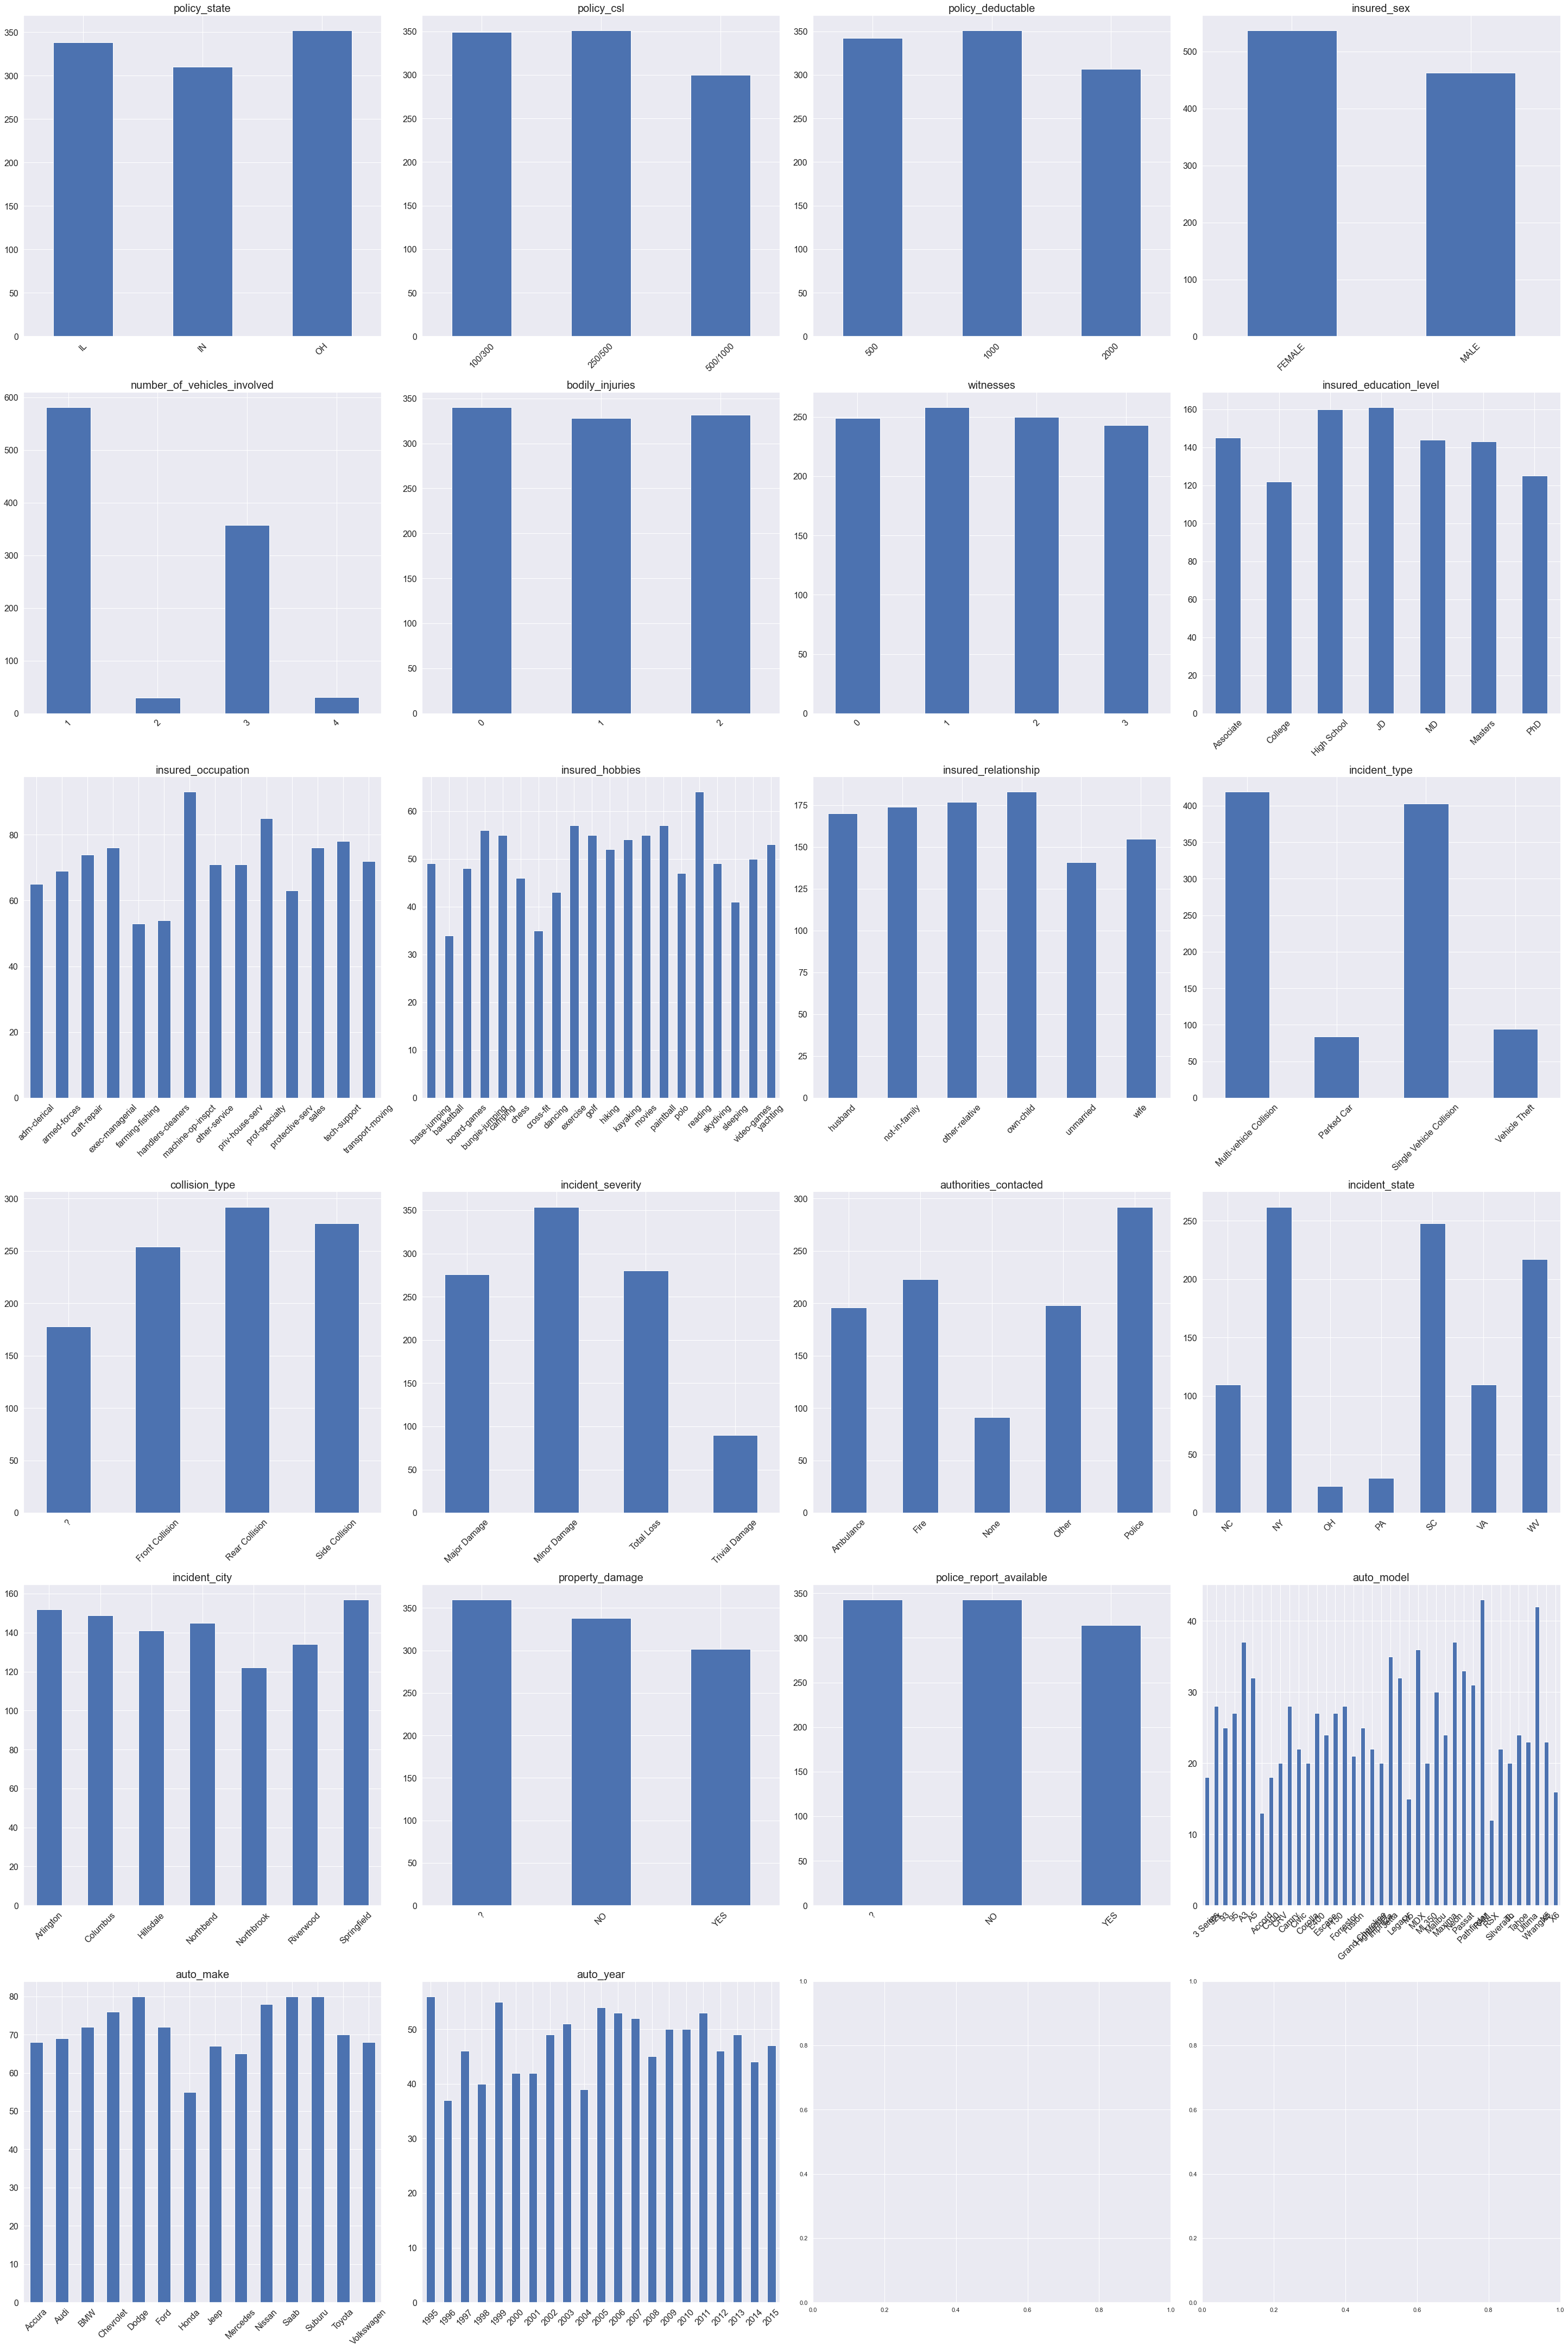

In [10]:
fig, ax = plt.subplots(6, 4, figsize=(40,60), constrained_layout=True)
for i in range(6):
    for j in range(4):
        if 4*i + j < len(cat_features):
            df[cat_features[4*i + j]].value_counts().sort_index().plot.bar(ax=ax[i, j])
            ax[i, j].tick_params('x', rotation=45)
            ax[i, j].tick_params(labelsize=16)
            ax[i, j].set_title(cat_features[4*i + j], size=20)

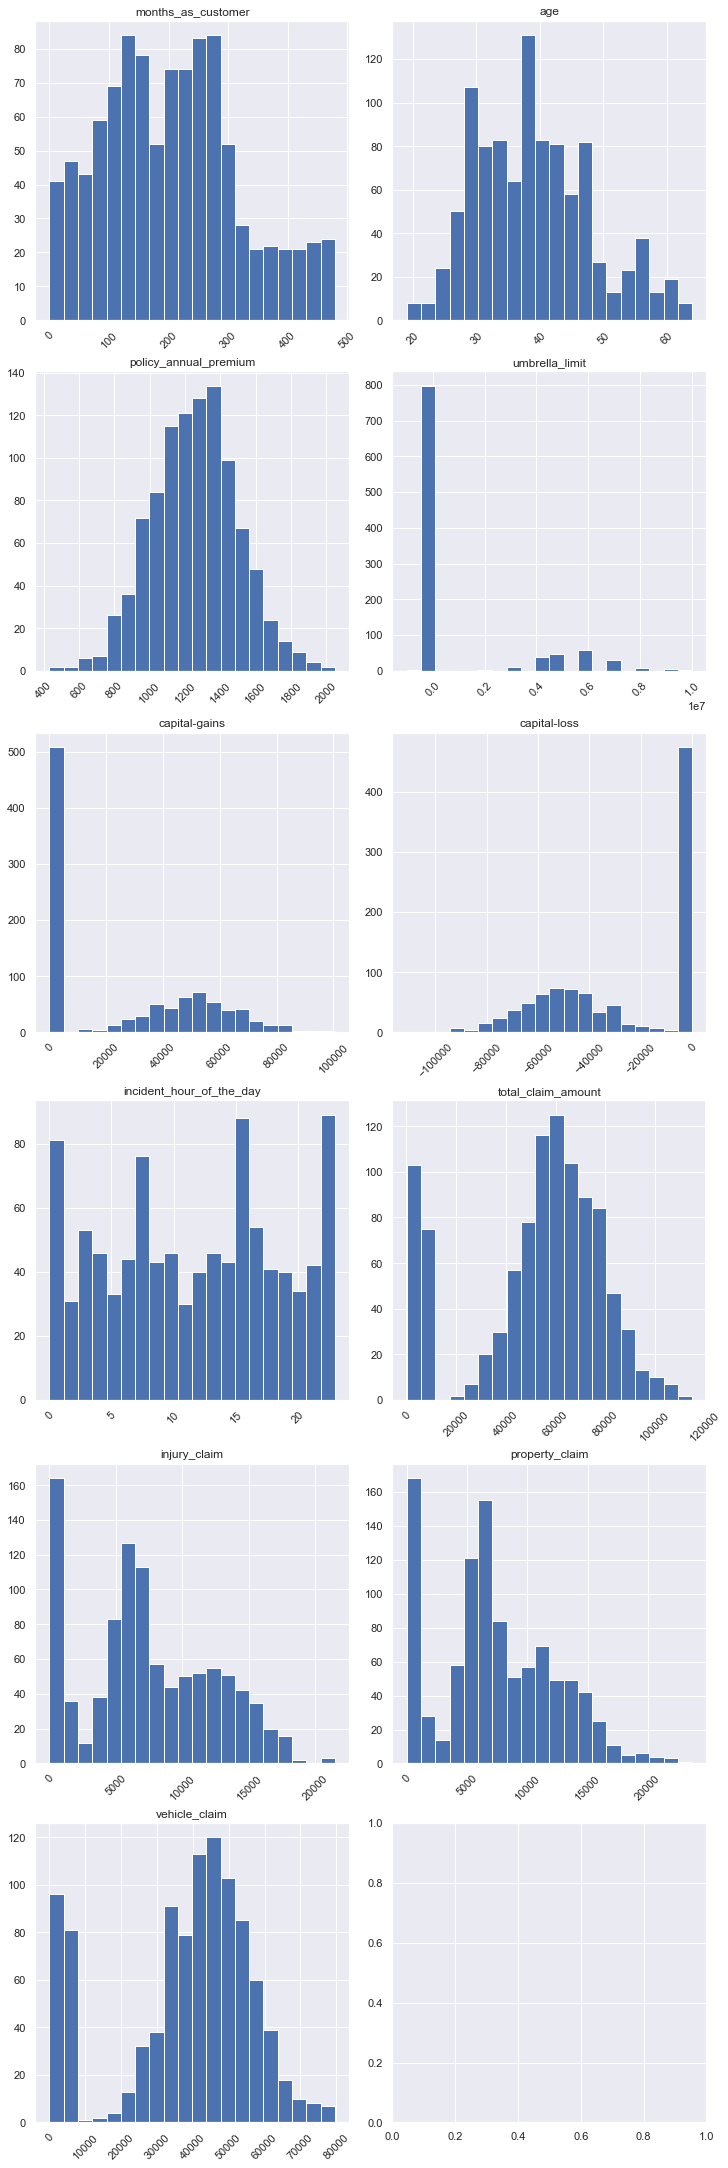

In [11]:
fig, ax = plt.subplots(6, 2, figsize=(10,30), constrained_layout=True)
for i in range(6):
    for j in range(2):
        if 2*i + j < len(num_features):
            df[num_features[2*i + j]].hist(bins=20, ax=ax[i, j])
            ax[i, j].tick_params('x', rotation=45)
            ax[i, j].set_title(num_features[2*i + j])

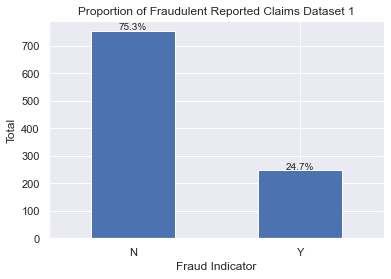

In [12]:
df['fraud_reported'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Fraud Indicator')
plt.ylabel('Total')
plt.title("Proportion of Fraudulent Reported Claims Dataset 1")
ax = plt.gca()
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height/df.shape[0]:.1%}', (x + width/2, y + height*1.01), ha='center', size=10)
plt.savefig("Image/Proportion of Fraudulent Reported Claims Dataset 1",
            bbox_inches='tight')

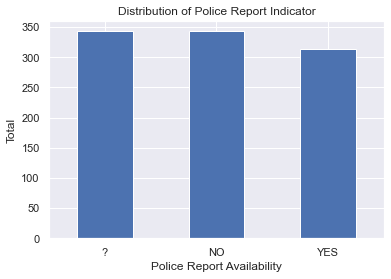

In [13]:
df['police_report_available'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Police Report Availability')
plt.ylabel('Total')
plt.title("Distribution of Police Report Indicator");

In [14]:
df['incident_year'] = pd.DatetimeIndex(df['incident_date']).year
df['incident_month'] = pd.DatetimeIndex(df['incident_date']).month
df['incident_day'] = pd.DatetimeIndex(df['incident_date']).dayofweek

In [15]:
X = df.drop('fraud_reported', axis=1)
y = df['fraud_reported'].apply(lambda x: 1 if x == 'Y' else 0)

In [16]:
num_r = 14
num_c = 13


def preprocessX(X_train, X_test, fit_IGTD=True, fit_IGTD_enhanced=False):
    X_train = X_train.drop(['policy_number', 'insured_zip', 'incident_location', 'policy_bind_date',
                            'total_claim_amount', 'incident_date'], axis=1)
    X_test = X_test.drop(['policy_number', 'insured_zip', 'incident_location', 'policy_bind_date',
                          'total_claim_amount', 'incident_date'], axis=1)

    X_train_cat = X_train[['policy_state', 'policy_csl', 'insured_sex',
                           'insured_education_level', 'insured_occupation', 'insured_hobbies',
                           'insured_relationship', 'incident_type',
                           'collision_type', 'incident_severity', 'authorities_contacted',
                           'incident_state', 'incident_city',
                           'property_damage', 'police_report_available', 'auto_model', 'auto_make',
                           'incident_day', 'incident_month']]
    X_train_num = X_train.drop(['policy_state', 'policy_csl', 'insured_sex',
                                'insured_education_level', 'insured_occupation', 'insured_hobbies',
                                'insured_relationship', 'incident_type',
                                'collision_type', 'incident_severity', 'authorities_contacted',
                                'incident_state', 'incident_city',
                                'property_damage', 'police_report_available', 'auto_model', 'auto_make',
                                'incident_day', 'incident_month'], axis=1).values

    X_test_cat = X_test[['policy_state', 'policy_csl', 'insured_sex',
                         'insured_education_level', 'insured_occupation', 'insured_hobbies',
                         'insured_relationship', 'incident_type',
                         'collision_type', 'incident_severity', 'authorities_contacted',
                         'incident_state', 'incident_city',
                         'property_damage', 'police_report_available', 'auto_model', 'auto_make',
                         'incident_day', 'incident_month']]
    X_test_num = X_test.drop(['policy_state', 'policy_csl', 'insured_sex',
                              'insured_education_level', 'insured_occupation', 'insured_hobbies',
                              'insured_relationship', 'incident_type',
                              'collision_type', 'incident_severity', 'authorities_contacted',
                              'incident_state', 'incident_city',
                              'property_damage', 'police_report_available', 'auto_model', 'auto_make',
                              'incident_day', 'incident_month'], axis=1).values

    onehot_enc = OneHotEncoder(handle_unknown='ignore')
    X_train_cat = onehot_enc.fit_transform(X_train_cat).toarray()
    X_test_cat = onehot_enc.transform(X_test_cat).toarray()

    X_train = np.concatenate([X_train_num, X_train_cat], axis=1)
    X_test = np.concatenate([X_test_num, X_test_cat], axis=1)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    num = num_r * num_c

    if fit_IGTD:
        X_train_IGTD = np.concatenate(
            [X_train, np.zeros((X_train.shape[0], max(num - X_train.shape[1], 0)))], axis=1)
        X_test_IGTD = np.concatenate(
            [X_test, np.zeros((X_test.shape[0], max(num - X_train.shape[1], 0)))], axis=1)

        X_train_IGTD = X_train_IGTD[:, :num]
        X_test_IGTD = X_test_IGTD[:, :num]

        if fit_IGTD_enhanced:
            feature_ranking, feature_corr = generate_feature_distance_ranking_enhanced(
                X_train_IGTD)
        else:
            feature_ranking, feature_corr = generate_feature_distance_ranking(
                X_train_IGTD)

        matrix_coordinate, matrix_dist_ranking = generate_matrix_distance_ranking(
            num_r, num_c)

        index_record, _, _ = IGTD(
            source=feature_ranking, target=matrix_dist_ranking, err_measure='squared')
        X_train_IGTD = np.reshape(
            X_train_IGTD[:, index_record[-1]], (-1, num_r, num_c, 1))
        X_test_IGTD = np.reshape(
            X_test_IGTD[:, index_record[-1]], (-1, num_r, num_c, 1))
        return X_train, X_test, X_train_IGTD, X_test_IGTD
    else:
        return X_train, X_test


X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train_preprocessed, X_test_preprocessed, X_train_IGTD, X_test_IGTD = preprocessX(X_train1, X_test1)
_, _, X_train_IGTD_en, X_test_IGTD_en = preprocessX(X_train1, X_test1, fit_IGTD_enhanced=True)

In [17]:
p = X_train_preprocessed.shape[1]
p

171

In [18]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y),
                                                  y=y_train1)
class_weight_dict = dict(enumerate(class_weights))

In [19]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

## Decision Tree

In [20]:
# Cross Validation

accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []
roc_auc_scores = []

for train, test in kfold.split(X, y):
    model_dectree = DecisionTreeClassifier(class_weight=class_weight_dict)
    X_train, X_test = preprocessX(X.loc[train], X.loc[test], fit_IGTD=False)
    y_train, y_test = y[train], y[test]
    model_dectree.fit(X_train, y_train)
    y_pred_prob = model_dectree.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob >= .5).astype(int)
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    specificity_scores.append(recall_score(1 - y_test, 1 - y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_prob))

print('Mean Accuracy: ', np.mean(accuracy_scores))
print('Mean Precision: ', np.mean(precision_scores))
print('Mean Recall: ', np.mean(recall_scores))
print('Mean Specificity: ', np.mean(specificity_scores))
print('Mean F1 Scores: ', np.mean(f1_scores))
print('Mean ROC AUC: ', np.mean(roc_auc_scores))

Mean Accuracy:  0.777
Mean Precision:  0.5488138177611861
Mean Recall:  0.5821666666666667
Mean Specificity:  0.840561403508772
Mean F1 Scores:  0.5601620789386477
Mean ROC AUC:  0.7113640350877193


In [21]:
dec_tree_results_df = pd.DataFrame({'Accuracy': accuracy_scores,
                                    'Precision': precision_scores,
                                    'Recall': recall_scores,
                                    'Specificity': specificity_scores,
                                    'F1': f1_scores,
                                    'ROC AUC': roc_auc_scores})

dec_tree_results_df.loc['mean'] = dec_tree_results_df.mean()
dec_tree_results_df.loc['std dev'] = dec_tree_results_df.std()

dec_tree_results_df

,Accuracy,Precision,Recall,Specificity,F1,ROC AUC
0,0.790000,0.566667,0.680000,0.826667,0.618182,0.753333
1,0.670000,0.366667,0.440000,0.746667,0.400000,0.593333
2,0.770000,0.545455,0.480000,0.866667,0.510638,0.673333
3,0.850000,0.692308,0.720000,0.893333,0.705882,0.806667
4,0.750000,0.500000,0.720000,0.760000,0.590164,0.740000
5,0.830000,0.625000,0.800000,0.840000,0.701754,0.820000
6,0.780000,0.578947,0.440000,0.893333,0.500000,0.666667
7,0.780000,0.541667,0.541667,0.855263,0.541667,0.698465
8,0.790000,0.571429,0.500000,0.881579,0.533333,0.690789
9,0.760000,0.500000,0.500000,0.842105,0.500000,0.671053


## Random Forest

In [22]:
# Hyperparameter Tuning
model_rf = RandomForestClassifier(n_jobs=-1, class_weight=class_weight_dict)
clf = BayesSearchCV(model_rf,
                    {'n_estimators': [25, 50, 100, 200],
                     'min_samples_split': [2, 5, 10, 20, 40]})
clf.fit(X_train_preprocessed, y_train1)
clf.best_params_

OrderedDict([('min_samples_split', 40), ('n_estimators', 100)])

In [23]:
# Cross Validation

accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []
roc_auc_scores = []

for train, test in kfold.split(X, y):
    model_rf = clf.best_estimator_
    X_train, X_test = preprocessX(X.loc[train], X.loc[test], fit_IGTD=False)
    y_train, y_test = y[train], y[test]
    model_rf.fit(X_train, y_train)
    y_pred_prob = model_rf.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob >= .5).astype(int)
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    specificity_scores.append(recall_score(1 - y_test, 1 - y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_prob))

print('Mean Accuracy: ', np.mean(accuracy_scores))
print('Mean Precision: ', np.mean(precision_scores))
print('Mean Recall: ', np.mean(recall_scores))
print('Mean Specificity: ', np.mean(specificity_scores))
print('Mean F1 Scores: ', np.mean(f1_scores))
print('Mean ROC AUC: ', np.mean(roc_auc_scores))

Mean Accuracy:  0.8319999999999999
Mean Precision:  0.6314322985993199
Mean Recall:  0.7855
Mean Specificity:  0.8472280701754386
Mean F1 Scores:  0.6966194095136634
Mean ROC AUC:  0.8429219298245613


In [24]:
rf_results_df = pd.DataFrame({'Accuracy': accuracy_scores,
                              'Precision': precision_scores,
                              'Recall': recall_scores,
                              'Specificity': specificity_scores,
                              'F1': f1_scores,
                              'ROC AUC': roc_auc_scores})

rf_results_df.loc['mean'] = rf_results_df.mean()
rf_results_df.loc['std dev'] = rf_results_df.std()

rf_results_df

,Accuracy,Precision,Recall,Specificity,F1,ROC AUC
0,0.810000,0.583333,0.840000,0.800000,0.688525,0.861333
1,0.840000,0.621622,0.920000,0.813333,0.741935,0.844800
2,0.830000,0.625000,0.800000,0.840000,0.701754,0.844267
3,0.800000,0.586207,0.680000,0.840000,0.629630,0.862400
4,0.830000,0.611111,0.880000,0.813333,0.721311,0.867200
5,0.840000,0.666667,0.720000,0.880000,0.692308,0.840000
6,0.840000,0.695652,0.640000,0.906667,0.666667,0.784000
7,0.830000,0.612903,0.791667,0.842105,0.690909,0.875548
8,0.850000,0.645161,0.833333,0.855263,0.727273,0.834430
9,0.850000,0.666667,0.750000,0.881579,0.705882,0.815241


## XGBoost

In [25]:
model_xgb = xgb.XGBClassifier(eval_metric='auc',
                              n_jobs=-1, random_state=0, early_stopping_rounds=50, n_estimators = 500,
                              tree_method='gpu_hist')

sample_weights = class_weight.compute_sample_weight('balanced',
                                                    y=y_train1)

clf = BayesSearchCV(model_xgb,
                    {'eta': [0.02, 0.04, 0.06, 0.08, 0.1],
                     'max_depth': [5, 10, 20],
                     'gamma': [0, 1, 2, 5]}, random_state=1)
clf.fit(X_train_preprocessed, y_train1, verbose=False, sample_weight=sample_weights,
        eval_set=[(X_train_preprocessed, y_train1),
                  (X_test_preprocessed, y_test1)])
clf.best_params_

OrderedDict([('eta', 0.04), ('gamma', 5), ('max_depth', 5)])

In [26]:
# Cross Validation

accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []
roc_auc_scores = []

for train, test in kfold.split(X, y):
    model_xgb = clf.best_estimator_
    X_train, X_test = preprocessX(X.loc[train], X.loc[test], fit_IGTD=False)
    y_train, y_test = y[train], y[test]
    sample_weights = class_weight.compute_sample_weight('balanced',
                                                        y=y_train)
    model_xgb.fit(X_train, y_train, verbose=False, sample_weight=sample_weights,
                  eval_set=[(X_train, y_train),
                            (X_test, y_test)])
    y_pred_prob = model_xgb.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob >= .5).astype(int)
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    specificity_scores.append(recall_score(1 - y_test, 1 - y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_prob))

print('Mean Accuracy: ', np.mean(accuracy_scores))
print('Mean Precision: ', np.mean(precision_scores))
print('Mean Recall: ', np.mean(recall_scores))
print('Mean Specificity: ', np.mean(specificity_scores))
print('Mean F1 Scores: ', np.mean(f1_scores))
print('Mean ROC AUC: ', np.mean(roc_auc_scores))

print(classification_report(y_test, y_pred))

Mean Accuracy:  0.8540000000000001
Mean Precision:  0.6535746016318772
Mean Recall:  0.8865000000000001
Mean Specificity:  0.8432280701754384
Mean F1 Scores:  0.750453441046862
Mean ROC AUC:  0.8965288596491228
              precision    recall  f1-score   support

           0       0.93      0.88      0.91        76
           1       0.68      0.79      0.73        24

    accuracy                           0.86       100
   macro avg       0.80      0.84      0.82       100
weighted avg       0.87      0.86      0.86       100



In [27]:
xgb_results_df = pd.DataFrame({'Accuracy': accuracy_scores,
                               'Precision': precision_scores,
                               'Recall': recall_scores,
                               'Specificity': specificity_scores,
                               'F1': f1_scores,
                               'ROC AUC': roc_auc_scores})

xgb_results_df.loc['mean'] = xgb_results_df.mean()
xgb_results_df.loc['std dev'] = xgb_results_df.std()

xgb_results_df

,Accuracy,Precision,Recall,Specificity,F1,ROC AUC
0,0.830000,0.605263,0.920000,0.800000,0.730159,0.883733
1,0.840000,0.621622,0.920000,0.813333,0.741935,0.917333
2,0.850000,0.647059,0.880000,0.840000,0.745763,0.900533
3,0.850000,0.647059,0.880000,0.840000,0.745763,0.918133
4,0.820000,0.589744,0.920000,0.786667,0.718750,0.895200
5,0.890000,0.718750,0.920000,0.880000,0.807018,0.924533
6,0.870000,0.714286,0.800000,0.893333,0.754717,0.860800
7,0.870000,0.657143,0.958333,0.842105,0.779661,0.944079
8,0.860000,0.656250,0.875000,0.855263,0.750000,0.870340
9,0.860000,0.678571,0.791667,0.881579,0.730769,0.850603


## Imbalance-XGBoost Weighted Function

In [28]:
params = model_xgb.get_xgb_params()
del params['objective']

# Searching For Best imbalance_alpha
auc_score_list = []
for i in np.arange(1.1, 5.1, 0.1):
    model4 = xgb.cv(params=params, dtrain=xgb.DMatrix(X_train_preprocessed, label=y_train1),
                    obj=Weight_Binary_Cross_Entropy(
                        imbalance_alpha=i).weighted_binary_cross_entropy,
                    nfold=10, num_boost_round=50, stratified=True)
    auc_score_list.append(model4['test-auc-mean'].mean())

max_auc4 = max(auc_score_list)
max_index4 = auc_score_list.index(max_auc4)
best_imb_alpha = 1.1 + max_index4*0.1
best_imb_alpha

1.2000000000000002

In [29]:

accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []
roc_auc_scores = []

for train, test in kfold.split(X, y):
    X_train, X_test = preprocessX(X.loc[train], X.loc[test], fit_IGTD=False)
    y_train, y_test = y[train], y[test]
    model_imxgb = xgb.train(params=params, dtrain=xgb.DMatrix(X_train, label=y_train),
                            obj=Weight_Binary_Cross_Entropy(imbalance_alpha=best_imb_alpha).weighted_binary_cross_entropy)
    raw = model_imxgb.predict(xgb.DMatrix(X_test, label=y_test))

    y_pred_prob = 1. / (1. + np.exp(-raw))
    y_pred = (y_pred_prob >= .5).astype(int)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    specificity_scores.append(recall_score(1 - y_test, 1 - y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_prob))

print('Mean Accuracy: ', np.mean(accuracy_scores))
print('Mean Precision: ', np.mean(precision_scores))
print('Mean Recall: ', np.mean(recall_scores))
print('Mean Specificity: ', np.mean(specificity_scores))
print('Mean F1 Scores: ', np.mean(f1_scores))
print('Mean ROC AUC: ', np.mean(roc_auc_scores))

print(classification_report(y_test, y_pred))

Mean Accuracy:  0.8540000000000001
Mean Precision:  0.6535746016318772
Mean Recall:  0.8865000000000001
Mean Specificity:  0.8432280701754384
Mean F1 Scores:  0.750453441046862
Mean ROC AUC:  0.8718632017543859
              precision    recall  f1-score   support

           0       0.93      0.88      0.91        76
           1       0.68      0.79      0.73        24

    accuracy                           0.86       100
   macro avg       0.80      0.84      0.82       100
weighted avg       0.87      0.86      0.86       100



In [30]:
imxgb_results_df = pd.DataFrame({'Accuracy': accuracy_scores,
                                 'Precision': precision_scores,
                                 'Recall': recall_scores,
                                 'Specificity': specificity_scores,
                                 'F1': f1_scores,
                                 'ROC AUC': roc_auc_scores})

imxgb_results_df.loc['mean'] = imxgb_results_df.mean()
imxgb_results_df.loc['std dev'] = imxgb_results_df.std()

imxgb_results_df

,Accuracy,Precision,Recall,Specificity,F1,ROC AUC
0,0.830000,0.605263,0.920000,0.800000,0.730159,0.875733
1,0.840000,0.621622,0.920000,0.813333,0.741935,0.877067
2,0.850000,0.647059,0.880000,0.840000,0.745763,0.873867
3,0.850000,0.647059,0.880000,0.840000,0.745763,0.873333
4,0.820000,0.589744,0.920000,0.786667,0.718750,0.865067
5,0.890000,0.718750,0.920000,0.880000,0.807018,0.926400
6,0.870000,0.714286,0.800000,0.893333,0.754717,0.830400
7,0.870000,0.657143,0.958333,0.842105,0.779661,0.909814
8,0.860000,0.656250,0.875000,0.855263,0.750000,0.851151
9,0.860000,0.678571,0.791667,0.881579,0.730769,0.835800


## Multi Layer Perceptron

In [31]:
def model_builder(hp):
    model = models.Sequential([layers.Dense(hp.Choice('unit_1', values=[64, 128, 256, 512]),
                                            activation='relu', input_shape=(p, )), layers.Dropout(.25),
                               layers.Dense(hp.Choice('unit_2', values=[32, 64, 128, 256]),
                                            activation='relu'), layers.Dropout(.25),
                               layers.Dense(hp.Choice('unit_3', values=[16, 32, 64, 128]),
                                            activation='relu'), layers.Dropout(.25),
                               layers.Dense(1, activation='sigmoid')])
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])))
    return model


tuner = kt.BayesianOptimization(
    hypermodel=model_builder,
    objective="val_loss",
    max_trials=50,
    overwrite=True,
    directory="Hasil",
    project_name="MLP",
    seed=1
)

early_stopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20,
                                         restore_best_weights=True)

tuner.search(X_train_preprocessed, y_train1, batch_size=16, epochs=200,
             validation_data=(X_test_preprocessed, y_test1), class_weight=class_weight_dict, callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters()[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first dense
layer is {best_hps.get('unit_1')}, The optimal number of units in the second dense
layer is {best_hps.get('unit_2')}, The optimal number of units in the third dense
layer is {best_hps.get('unit_3')}, and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 50 Complete [00h 00m 08s]
val_loss: 0.5056188702583313

Best val_loss So Far: 0.43423935770988464
Total elapsed time: 00h 09m 14s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first dense
layer is 64, The optimal number of units in the second dense
layer is 256, The optimal number of units in the third dense
layer is 16, and the optimal learning rate for the optimizer
is 0.001.



In [32]:

accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []
roc_auc_scores = []

for train, test in kfold.split(X, y):
    X_train, X_test = preprocessX(X.loc[train], X.loc[test], fit_IGTD=False)
    y_train, y_test = y[train], y[test]

    model_mlp = tuner.hypermodel.build(best_hps)
    model_mlp.fit(X_train, y_train, batch_size=32, epochs=200, verbose=0,
                  validation_data=(X_test, y_test), class_weight=class_weight_dict, callbacks=[early_stopping])

    y_pred_prob = model_mlp.predict(X_test)[:, 0]
    y_pred = (y_pred_prob >= .5).astype(int)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    specificity_scores.append(recall_score(1 - y_test, 1 - y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_prob))

print('Mean Accuracy: ', np.mean(accuracy_scores))
print('Mean Precision: ', np.mean(precision_scores))
print('Mean Recall: ', np.mean(recall_scores))
print('Mean Specificity: ', np.mean(specificity_scores))
print('Mean F1 Scores: ', np.mean(f1_scores))
print('Mean ROC AUC: ', np.mean(roc_auc_scores))

print(classification_report(y_test, y_pred))

Mean Accuracy:  0.8140000000000001
Mean Precision:  0.6108117853864224
Mean Recall:  0.7045
Mean Specificity:  0.8498245614035088
Mean F1 Scores:  0.6509712224984987
Mean ROC AUC:  0.8314675438596492
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        76
           1       0.63      0.50      0.56        24

    accuracy                           0.81       100
   macro avg       0.74      0.70      0.72       100
weighted avg       0.80      0.81      0.80       100



In [33]:
mlp_results_df = pd.DataFrame({'Accuracy': accuracy_scores,
                               'Precision': precision_scores,
                               'Recall': recall_scores,
                               'Specificity': specificity_scores,
                               'F1': f1_scores,
                               'ROC AUC': roc_auc_scores})

mlp_results_df.loc['mean'] = mlp_results_df.mean()
mlp_results_df.loc['std dev'] = mlp_results_df.std()

mlp_results_df

,Accuracy,Precision,Recall,Specificity,F1,ROC AUC
0,0.840000,0.666667,0.720000,0.880000,0.692308,0.865067
1,0.780000,0.551724,0.640000,0.826667,0.592593,0.820267
2,0.790000,0.562500,0.720000,0.813333,0.631579,0.842667
3,0.830000,0.653846,0.680000,0.880000,0.666667,0.832533
4,0.800000,0.575758,0.760000,0.813333,0.655172,0.829867
5,0.830000,0.642857,0.720000,0.866667,0.679245,0.811200
6,0.760000,0.515152,0.680000,0.786667,0.586207,0.763733
7,0.880000,0.714286,0.833333,0.894737,0.769231,0.895833
8,0.820000,0.593750,0.791667,0.828947,0.678571,0.825658
9,0.810000,0.631579,0.500000,0.907895,0.558140,0.827851


## IGTD + CNN

In [34]:
def model_builder2(hp):
    model = models.Sequential([layers.Conv2D(hp.Choice('filters', values=[8, 16, 32, 64]),
                                             hp.Choice('kernel_size', values=[
                                                       3, 4, 5, 6, 7]),
                                             input_shape=(num_r, num_c, 1), activation='relu'),
                               layers.SpatialDropout2D(.25),

                               layers.Flatten(),

                               layers.Dense(hp.Choice('unit_4', values=[4, 8, 16, 32]),
                                            activation='relu'), layers.Dropout(.25),
                               layers.Dense(1, activation='sigmoid')])

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])))
    return model


tuner = kt.BayesianOptimization(
    hypermodel=model_builder2,
    objective="val_loss",
    max_trials=50,
    overwrite=True,
    seed=1,
    directory="Hasil",
    project_name="CNN"
)

early_stopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20,
                                         restore_best_weights=True)

tuner.search(X_train_IGTD, y_train1, batch_size=32, epochs=200,
             validation_data=(X_test_IGTD, y_test1), class_weight=class_weight_dict, callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters()[0]
print(f"""
The hyperparameter search is complete. The optimal number of filters is {best_hps.get('filters')},
The optimal size of kernel is {best_hps.get('kernel_size')},
The optimal number of units in the first fully-connected layer is {best_hps.get('unit_4')},
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 50 Complete [00h 00m 39s]
val_loss: 0.5005403757095337

Best val_loss So Far: 0.38448119163513184
Total elapsed time: 00h 14m 51s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of filters is 8,
The optimal size of kernel is 6,
The optimal number of units in the first fully-connected layer is 4,
and the optimal learning rate for the optimizer is 0.001.



In [35]:

accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []
roc_auc_scores = []

for train, test in kfold.split(X, y):
    _, _, X_train, X_test = preprocessX(X.loc[train], X.loc[test])
    y_train, y_test = y[train], y[test]

    model_igtd_cnn = tuner.hypermodel.build(best_hps)
    model_igtd_cnn.fit(X_train, y_train, batch_size=32, epochs=200, verbose=0,
                  validation_data=(X_test, y_test), class_weight=class_weight_dict, callbacks=[early_stopping])

    y_pred_prob = model_igtd_cnn.predict(X_test)[:, 0]
    y_pred = (y_pred_prob >= .5).astype(int)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    specificity_scores.append(recall_score(1 - y_test, 1 - y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_prob))

print('Mean Accuracy: ', np.mean(accuracy_scores))
print('Mean Precision: ', np.mean(precision_scores))
print('Mean Recall: ', np.mean(recall_scores))
print('Mean Specificity: ', np.mean(specificity_scores))
print('Mean F1 Scores: ', np.mean(f1_scores))
print('Mean ROC AUC: ', np.mean(roc_auc_scores))

print(classification_report(y_test, y_pred))

Mean Accuracy:  0.8370000000000001
Mean Precision:  0.6514992224647397
Mean Recall:  0.745
Mean Specificity:  0.8671929824561403
Mean F1 Scores:  0.6907351703276265
Mean ROC AUC:  0.8565030701754385
              precision    recall  f1-score   support

           0       0.89      0.86      0.87        76
           1       0.59      0.67      0.63        24

    accuracy                           0.81       100
   macro avg       0.74      0.76      0.75       100
weighted avg       0.82      0.81      0.81       100



In [36]:
igtd_cnn_results_df = pd.DataFrame({'Accuracy': accuracy_scores,
                                    'Precision': precision_scores,
                                    'Recall': recall_scores,
                                    'Specificity': specificity_scores,
                                    'F1': f1_scores,
                                    'ROC AUC': roc_auc_scores})

igtd_cnn_results_df.loc['mean'] = igtd_cnn_results_df.mean()
igtd_cnn_results_df.loc['std dev'] = igtd_cnn_results_df.std()

igtd_cnn_results_df

,Accuracy,Precision,Recall,Specificity,F1,ROC AUC
0,0.800000,0.567568,0.840000,0.786667,0.677419,0.863467
1,0.790000,0.590909,0.520000,0.880000,0.553191,0.826133
2,0.870000,0.700000,0.840000,0.880000,0.763636,0.919467
3,0.850000,0.727273,0.640000,0.920000,0.680851,0.862667
4,0.820000,0.600000,0.840000,0.813333,0.700000,0.862933
5,0.880000,0.724138,0.840000,0.893333,0.777778,0.872533
6,0.840000,0.680000,0.680000,0.893333,0.680000,0.810133
7,0.870000,0.689655,0.833333,0.881579,0.754717,0.881031
8,0.840000,0.642857,0.750000,0.868421,0.692308,0.839912
9,0.810000,0.592593,0.666667,0.855263,0.627451,0.826754


## IGTD Modified + CNN

In [37]:
def model_builder2(hp):
    model = models.Sequential([layers.Conv2D(hp.Choice('filters', values=[8, 16, 32, 64]),
                                             hp.Choice('kernel_size', values=[
                                                       3, 4, 5, 6, 7]),
                                             input_shape=(num_r, num_c, 1), activation='relu'),
                               layers.SpatialDropout2D(.25),

                               layers.Flatten(),

                               layers.Dense(hp.Choice('unit_4', values=[4, 8, 16, 32]),
                                            activation='relu'), layers.Dropout(.25),
                               layers.Dense(1, activation='sigmoid')])

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])))
    return model


tuner = kt.BayesianOptimization(
    hypermodel=model_builder2,
    objective="val_loss",
    max_trials=50,
    overwrite=True,
    directory="Hasil",
    project_name="CNN",
    seed=1
)

early_stopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20,
                                         restore_best_weights=True)

tuner.search(X_train_IGTD_en, y_train1, batch_size=32, epochs=200,
             validation_data=(X_test_IGTD, y_test1), class_weight=class_weight_dict, callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters()[0]
print(f"""
The hyperparameter search is complete. The optimal number of filters is {best_hps.get('filters')},
The optimal size of kernel is {best_hps.get('kernel_size')},
The optimal number of units in the first fully-connected layer is {best_hps.get('unit_4')},
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 50 Complete [00h 00m 06s]
val_loss: 0.6231831312179565

Best val_loss So Far: 0.569663405418396
Total elapsed time: 00h 07m 56s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of filters is 8,
The optimal size of kernel is 7,
The optimal number of units in the first fully-connected layer is 4,
and the optimal learning rate for the optimizer is 0.001.



In [38]:

accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []
roc_auc_scores = []

for train, test in kfold.split(X, y):
    _, _, X_train, X_test = preprocessX(X.loc[train], X.loc[test], fit_IGTD_enhanced=True)
    y_train, y_test = y[train], y[test]

    model_igtd_en_cnn = tuner.hypermodel.build(best_hps)
    model_igtd_en_cnn.fit(X_train, y_train, batch_size=32, epochs=200, verbose=0,
                  validation_data=(X_test, y_test), class_weight=class_weight_dict, callbacks=[early_stopping])

    y_pred_prob = model_igtd_en_cnn.predict(X_test)[:, 0]
    y_pred = (y_pred_prob >= .5).astype(int)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    specificity_scores.append(recall_score(1 - y_test, 1 - y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_prob))

print('Mean Accuracy: ', np.mean(accuracy_scores))
print('Mean Precision: ', np.mean(precision_scores))
print('Mean Recall: ', np.mean(recall_scores))
print('Mean Specificity: ', np.mean(specificity_scores))
print('Mean F1 Scores: ', np.mean(f1_scores))
print('Mean ROC AUC: ', np.mean(roc_auc_scores))

print(classification_report(y_test, y_pred))

Mean Accuracy:  0.833
Mean Precision:  0.639726509007554
Mean Recall:  0.7521666666666667
Mean Specificity:  0.8591403508771929
Mean F1 Scores:  0.6883275211132813
Mean ROC AUC:  0.8567848245614036
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        76
           1       0.64      0.58      0.61        24

    accuracy                           0.82       100
   macro avg       0.75      0.74      0.75       100
weighted avg       0.82      0.82      0.82       100



In [39]:
igtd_en_cnn_results_df = pd.DataFrame({'Accuracy': accuracy_scores,
                                    'Precision': precision_scores,
                                    'Recall': recall_scores,
                                    'Specificity': specificity_scores,
                                    'F1': f1_scores,
                                    'ROC AUC': roc_auc_scores})

igtd_en_cnn_results_df.loc['mean'] = igtd_en_cnn_results_df.mean()
igtd_en_cnn_results_df.loc['std dev'] = igtd_en_cnn_results_df.std()

igtd_en_cnn_results_df

,Accuracy,Precision,Recall,Specificity,F1,ROC AUC
0,0.770000,0.526316,0.800000,0.760000,0.634921,0.823467
1,0.830000,0.617647,0.840000,0.826667,0.711864,0.830400
2,0.820000,0.629630,0.680000,0.866667,0.653846,0.873067
3,0.860000,0.689655,0.800000,0.880000,0.740741,0.874133
4,0.860000,0.677419,0.840000,0.866667,0.750000,0.883733
5,0.880000,0.709677,0.880000,0.880000,0.785714,0.907200
6,0.810000,0.615385,0.640000,0.866667,0.627451,0.812800
7,0.850000,0.655172,0.791667,0.868421,0.716981,0.902961
8,0.830000,0.640000,0.666667,0.881579,0.653061,0.855263
9,0.820000,0.636364,0.583333,0.894737,0.608696,0.804825


In [40]:
with pd.ExcelWriter('Result3.xlsx') as writer:
    dec_tree_results_df.to_excel(writer, sheet_name='Decision Tree')
    rf_results_df.to_excel(writer, sheet_name='Random Forest')
    xgb_results_df.to_excel(writer, sheet_name='XGB')
    imxgb_results_df.to_excel(writer, sheet_name='Im XGB Weighted Func')
    mlp_results_df.to_excel(writer, sheet_name='MLP')
    igtd_cnn_results_df.to_excel(writer, sheet_name='IGTD CNN')
    igtd_en_cnn_results_df.to_excel(writer, sheet_name='IGTD Enhanced CNN')

## Data 2

In [41]:
df2 = pd.read_csv("fraud_oracle.csv")
df2.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [42]:
df2.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


In [43]:
df2.dtypes

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePoli

In [44]:
df2.isna().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

In [45]:
df2.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy'],
      dtype='object')

In [46]:
cat_features = ['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'RepNumber',
       'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 
       'BasePolicy']
num_features = ['Age', 'Deductible', 'Year']

In [47]:
len(cat_features), len(num_features)

(28, 3)

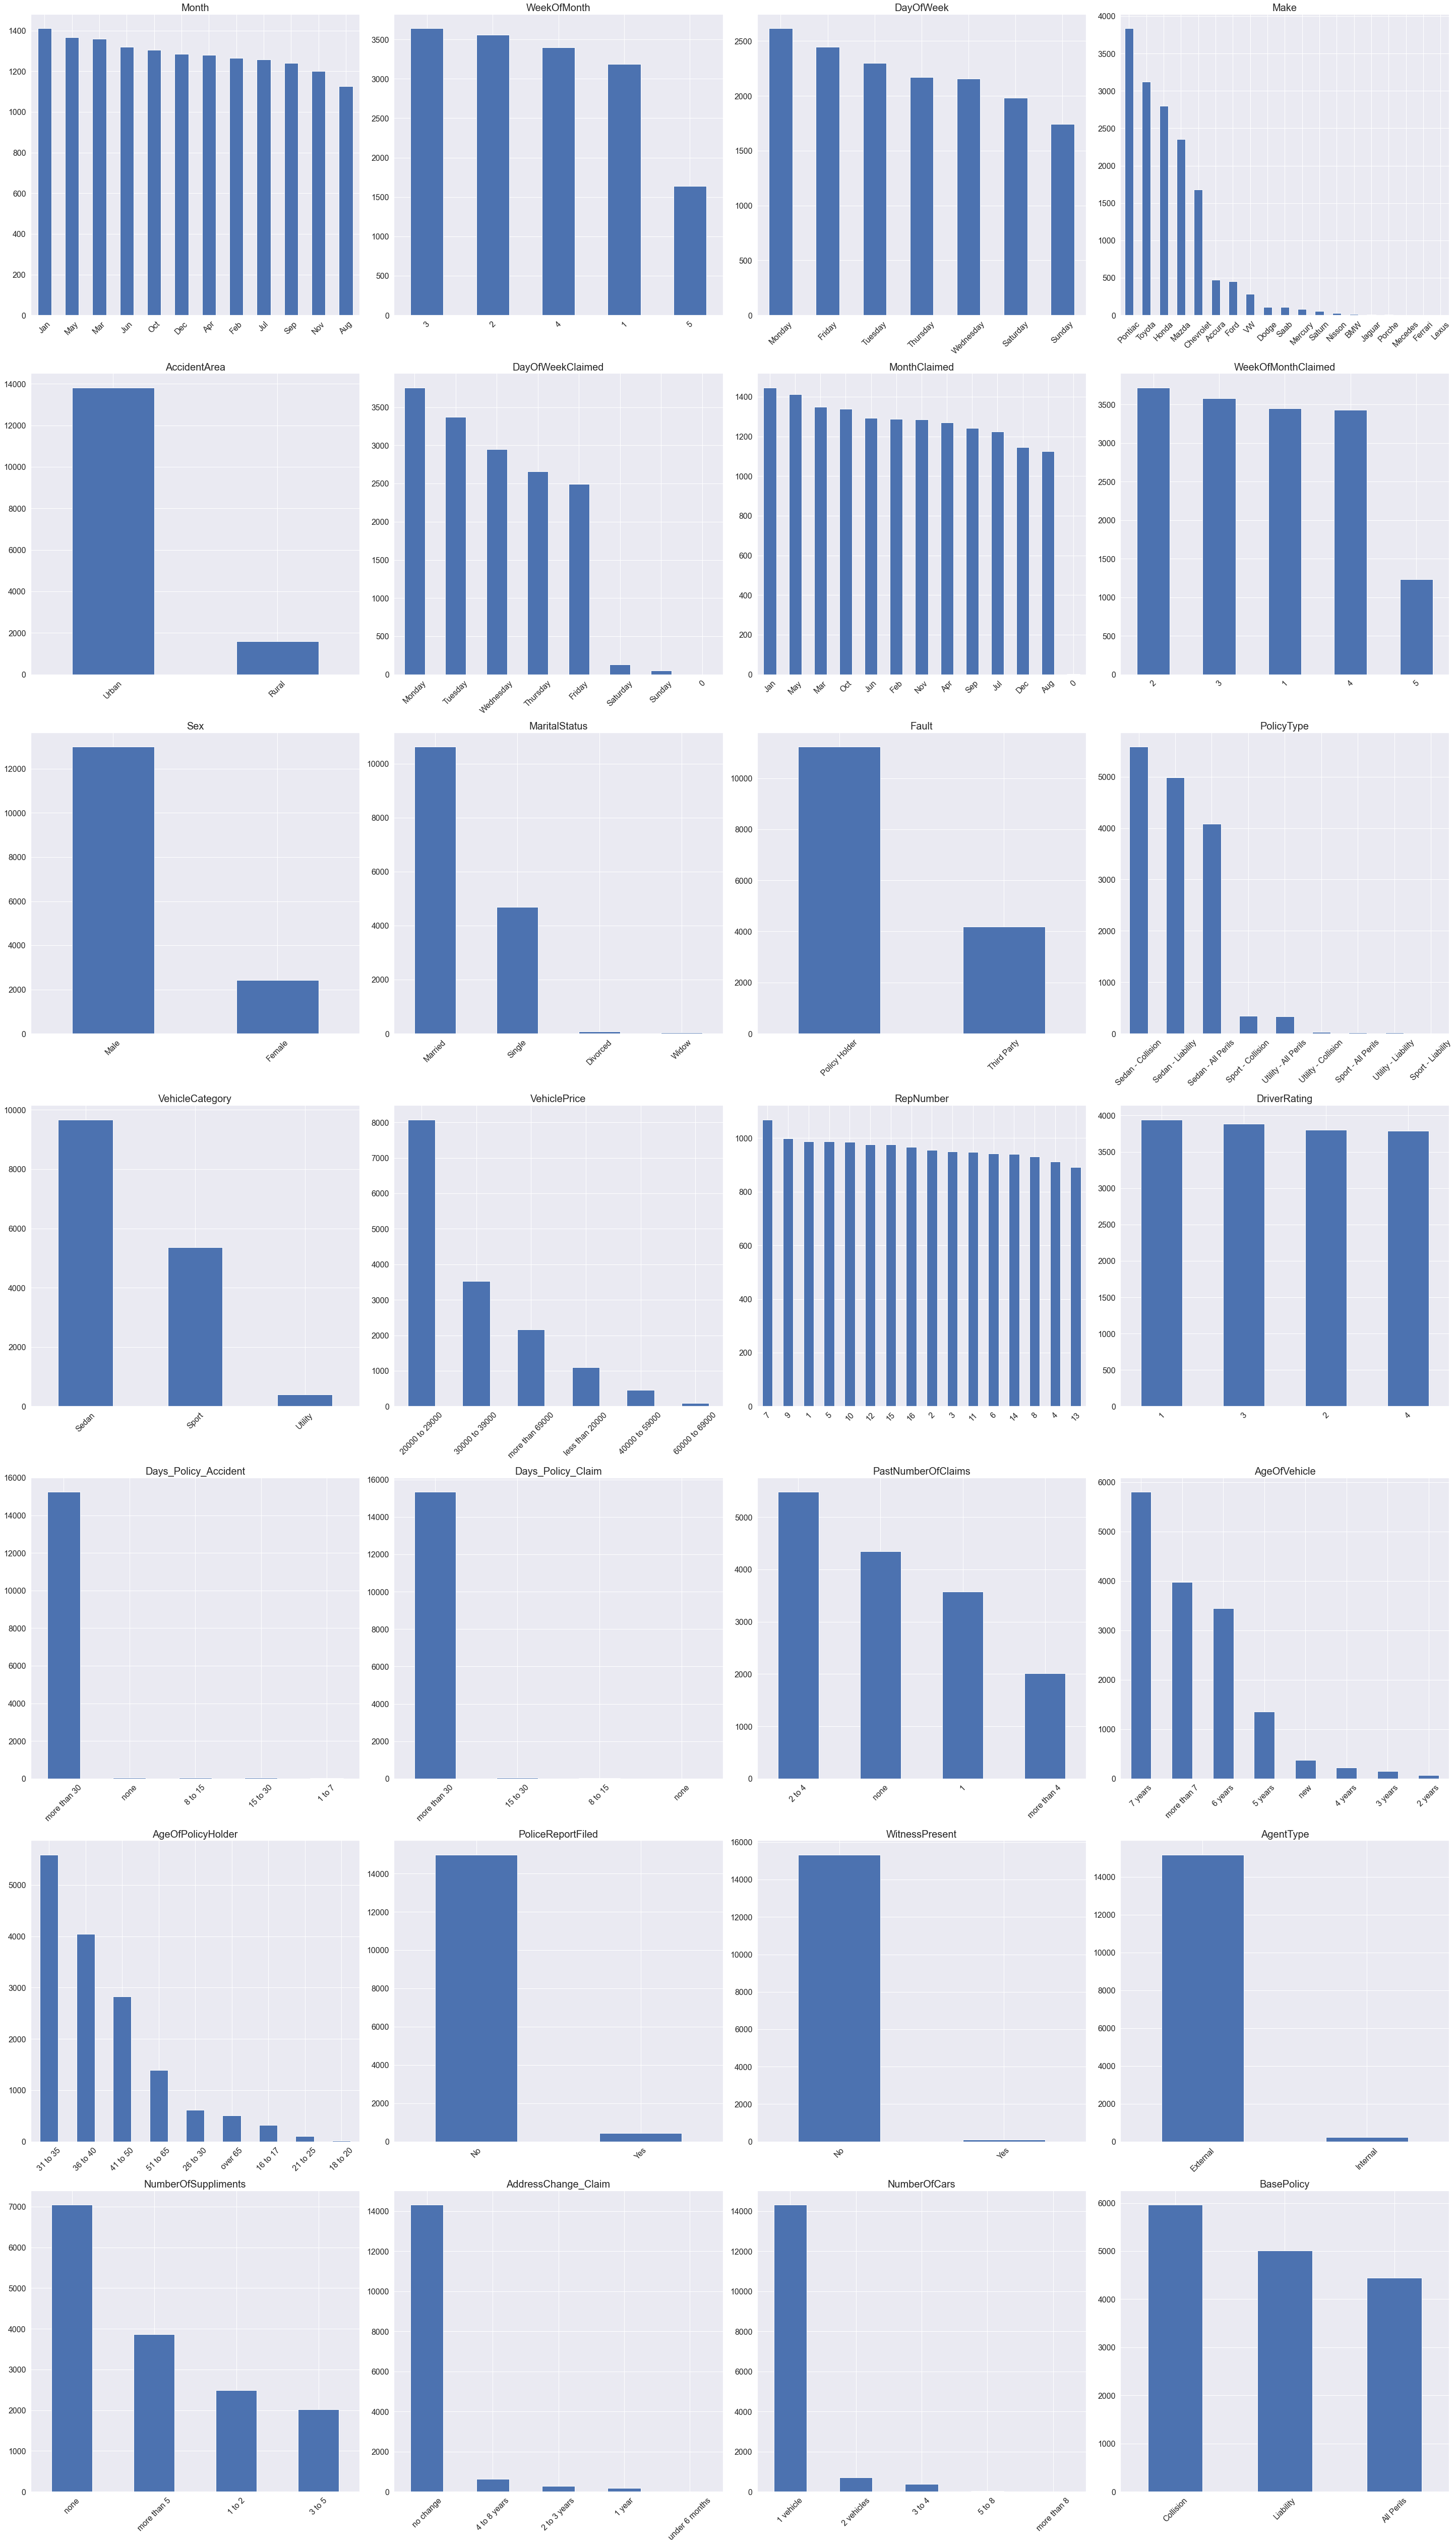

In [48]:
fig, ax = plt.subplots(7, 4, figsize=(40,70), constrained_layout=True)
for i in range(7):
    for j in range(4):
        df2[cat_features[4*i + j]].value_counts().plot.bar(ax=ax[i, j])
        ax[i, j].tick_params('x', rotation=45)
        ax[i, j].tick_params(labelsize=16)
        ax[i, j].set_title(cat_features[4*i + j], size=20)

In [49]:
X = df2.drop('FraudFound_P', axis=1)
y = df2['FraudFound_P']

In [50]:
y.mean()

0.05985732814526589

In [51]:
X.shape

(15420, 32)

In [52]:
num_r = 14
num_c = 13


def preprocessX(X_train, X_test, fit_IGTD=True, fit_IGTD_enhanced=False):
    X_train = X_train.drop(['PolicyNumber'], axis=1)
    X_test = X_test.drop(['PolicyNumber'], axis=1)

    X_train_cat = X_train[['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'RepNumber',
       'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 
       'BasePolicy']]
    X_train_num = X_train[['Age', 'Deductible', 'Year']]

    X_test_cat = X_test[['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'RepNumber',
       'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 
       'BasePolicy']]
    X_test_num = X_test[['Age', 'Deductible', 'Year']]

    onehot_enc = OneHotEncoder(handle_unknown='ignore')
    X_train_cat = onehot_enc.fit_transform(X_train_cat).toarray()
    X_test_cat = onehot_enc.transform(X_test_cat).toarray()

    X_train = np.concatenate([X_train_num, X_train_cat], axis=1)
    X_test = np.concatenate([X_test_num, X_test_cat], axis=1)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    num = num_r * num_c

    if fit_IGTD:
        X_train_IGTD = np.concatenate(
            [X_train, np.zeros((X_train.shape[0], max(num - X_train.shape[1], 0)))], axis=1)
        X_test_IGTD = np.concatenate(
            [X_test, np.zeros((X_test.shape[0], max(num - X_train.shape[1], 0)))], axis=1)

        X_train_IGTD = X_train_IGTD[:, :num]
        X_test_IGTD = X_test_IGTD[:, :num]

        if fit_IGTD_enhanced:
            feature_ranking, feature_corr = generate_feature_distance_ranking_enhanced(
                X_train_IGTD)
        else:
            feature_ranking, feature_corr = generate_feature_distance_ranking(
                X_train_IGTD)
            
        matrix_coordinate, matrix_dist_ranking = generate_matrix_distance_ranking(
            num_r, num_c)

        index_record, _, _ = IGTD(
            source=feature_ranking, target=matrix_dist_ranking, err_measure='squared')
        X_train_IGTD = np.reshape(
            X_train_IGTD[:, index_record[-1]], (-1, num_r, num_c, 1))
        X_test_IGTD = np.reshape(
            X_test_IGTD[:, index_record[-1]], (-1, num_r, num_c, 1))
        return X_train, X_test, X_train_IGTD, X_test_IGTD
    else:
        return X_train, X_test


X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train_preprocessed, X_test_preprocessed, X_train_IGTD, X_test_IGTD = preprocessX(
    X_train1, X_test1)
_, _, X_train_IGTD_en, X_test_IGTD_en = preprocessX(X_train1, X_test1, fit_IGTD_enhanced=True)

In [53]:
X_train_preprocessed.shape, X_train_IGTD.shape

((12336, 173), (12336, 14, 13, 1))

In [54]:
p = X_train_preprocessed.shape[1]
p

173

In [55]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y),
                                                  y=y_train1)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.5318158303155717, 1: 8.357723577235772}

In [56]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

## Decision Tree

In [57]:
# Cross Validation


accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []
roc_auc_scores = []

for train, test in kfold.split(X, y):
    model_dectree = DecisionTreeClassifier(class_weight=class_weight_dict)
    X_train, X_test = preprocessX(X.loc[train], X.loc[test], fit_IGTD=False)
    y_train, y_test = y[train], y[test]
    model_dectree.fit(X_train, y_train)
    y_pred_prob = model_dectree.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob >= .5).astype(int)
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    specificity_scores.append(recall_score(1 - y_test, 1 - y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_prob))

print('Mean Accuracy: ', np.mean(accuracy_scores))
print('Mean Precision: ', np.mean(precision_scores))
print('Mean Recall: ', np.mean(recall_scores))
print('Mean Specificity: ', np.mean(specificity_scores))
print('Mean F1 Scores: ', np.mean(f1_scores))
print('Mean ROC AUC: ', np.mean(roc_auc_scores))

Mean Accuracy:  0.8994163424124514
Mean Precision:  0.19535312225780346
Mean Recall:  0.21552127162225337
Mean Specificity:  0.9429531424763808
Mean F1 Scores:  0.2046146819240378
Mean ROC AUC:  0.5792372070493171


In [58]:
dec_tree_results_df = pd.DataFrame({'Accuracy': accuracy_scores,
                                    'Precision': precision_scores,
                                    'Recall': recall_scores,
                                    'Specificity': specificity_scores,
                                    'F1': f1_scores,
                                    'ROC AUC': roc_auc_scores})

dec_tree_results_df.loc['mean'] = dec_tree_results_df.mean()
dec_tree_results_df.loc['std dev'] = dec_tree_results_df.std()

dec_tree_results_df

,Accuracy,Precision,Recall,Specificity,F1,ROC AUC
0,0.893645,0.172727,0.206522,0.937241,0.188119,0.571882
1,0.895590,0.136842,0.141304,0.943448,0.139037,0.542376
2,0.890402,0.140187,0.163043,0.936552,0.150754,0.549798
3,0.906615,0.223404,0.228261,0.949655,0.225806,0.588958
4,0.901427,0.200000,0.217391,0.944828,0.208333,0.581109
5,0.898833,0.186275,0.206522,0.942759,0.195876,0.574640
6,0.913748,0.274725,0.271739,0.954483,0.273224,0.613111
7,0.902075,0.204082,0.215054,0.946170,0.209424,0.580612
8,0.887160,0.165289,0.215054,0.930297,0.186916,0.572675
9,0.904669,0.250000,0.290323,0.944099,0.268657,0.617211


## Random Forest

In [59]:
# Hyperparameter Tuning
model_rf = RandomForestClassifier(n_jobs=-1, class_weight=class_weight_dict)
clf = BayesSearchCV(model_rf,
                    {'n_estimators': [25, 50, 100, 200, 400, 800],
                     'min_samples_split': [2, 5, 10, 20, 40, 80]})
clf.fit(X_train_preprocessed, y_train1)
clf.best_params_

OrderedDict([('min_samples_split', 5), ('n_estimators', 200)])

In [60]:
# Cross Validation


accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []
roc_auc_scores = []

for train, test in kfold.split(X, y):
    model_rf = clf.best_estimator_
    X_train, X_test = preprocessX(X.loc[train], X.loc[test], fit_IGTD=False)
    y_train, y_test = y[train], y[test]
    model_rf.fit(X_train, y_train)
    y_pred_prob = model_rf.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob >= .5).astype(int)
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    specificity_scores.append(recall_score(1 - y_test, 1 - y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_prob))

print('Mean Accuracy: ', np.mean(accuracy_scores))
print('Mean Precision: ', np.mean(precision_scores))
print('Mean Recall: ', np.mean(recall_scores))
print('Mean Specificity: ', np.mean(specificity_scores))
print('Mean F1 Scores: ', np.mean(f1_scores))
print('Mean ROC AUC: ', np.mean(roc_auc_scores))

Mean Accuracy:  0.9413748378728923
Mean Precision:  0.8166666666666667
Mean Recall:  0.02703366058906031
Mean Specificity:  0.9995861117060517
Mean F1 Scores:  0.05199214852284993
Mean ROC AUC:  0.8294322690165414


In [61]:
rf_results_df = pd.DataFrame({'Accuracy': accuracy_scores,
                              'Precision': precision_scores,
                              'Recall': recall_scores,
                              'Specificity': specificity_scores,
                              'F1': f1_scores,
                              'ROC AUC': roc_auc_scores})

rf_results_df.loc['mean'] = rf_results_df.mean()
rf_results_df.loc['std dev'] = rf_results_df.std()

rf_results_df

,Accuracy,Precision,Recall,Specificity,F1,ROC AUC
0,0.941634,1.000000,0.021739,1.000000,0.042553,0.843883
1,0.941634,0.750000,0.032609,0.999310,0.062500,0.824636
2,0.940986,1.000000,0.010870,1.000000,0.021505,0.839483
3,0.940337,0.500000,0.010870,0.999310,0.021277,0.817331
4,0.941634,1.000000,0.021739,1.000000,0.042553,0.841061
5,0.940337,0.500000,0.010870,0.999310,0.021277,0.820075
6,0.941634,0.750000,0.032609,0.999310,0.062500,0.831912
7,0.942283,1.000000,0.043011,1.000000,0.082474,0.828332
8,0.942283,1.000000,0.043011,1.000000,0.082474,0.821939
9,0.940986,0.666667,0.043011,0.998620,0.080808,0.825671


## XGBoost

In [62]:
model_xgb = xgb.XGBClassifier(eval_metric='auc',
                              n_jobs=-1, random_state=0, early_stopping_rounds=50, n_estimators = 1000,
                              tree_method='gpu_hist')

sample_weights = class_weight.compute_sample_weight('balanced',
                                                    y=y_train1)

clf = BayesSearchCV(model_xgb,
                    {'eta': [0.02, 0.04, 0.06, 0.08, 0.1],
                     'max_depth': [5, 10, 20],
                     'gamma': [0, 1, 2, 5]}, random_state=1)
clf.fit(X_train_preprocessed, y_train1, verbose=False, sample_weight=sample_weights,
        eval_set=[(X_train_preprocessed, y_train1),
                  (X_test_preprocessed, y_test1)])
clf.best_params_

OrderedDict([('eta', 0.06), ('gamma', 0), ('max_depth', 20)])

In [63]:
# Cross Validation


accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []
roc_auc_scores = []

for train, test in kfold.split(X, y):
    model_xgb = clf.best_estimator_
    X_train, X_test = preprocessX(X.loc[train], X.loc[test], fit_IGTD=False)
    y_train, y_test = y[train], y[test]
    sample_weights = class_weight.compute_sample_weight('balanced',
                                                        y=y_train)
    model_xgb.fit(X_train, y_train, verbose=False, sample_weight=sample_weights,
                  eval_set=[(X_train, y_train),
                            (X_test, y_test)])
    y_pred_prob = model_xgb.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob >= .5).astype(int)
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    specificity_scores.append(recall_score(1 - y_test, 1 - y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_prob))

print('Mean Accuracy: ', np.mean(accuracy_scores))
print('Mean Precision: ', np.mean(precision_scores))
print('Mean Recall: ', np.mean(recall_scores))
print('Mean Specificity: ', np.mean(specificity_scores))
print('Mean F1 Scores: ', np.mean(f1_scores))
print('Mean ROC AUC: ', np.mean(roc_auc_scores))

print(classification_report(y_test, y_pred))

Mean Accuracy:  0.9123216601815825
Mean Precision:  0.27115110485791
Mean Recall:  0.21139551192145864
Mean Specificity:  0.9569613764546299
Mean F1 Scores:  0.2121541191880139
Mean ROC AUC:  0.8415646653119933
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1449
           1       0.38      0.20      0.27        93

    accuracy                           0.93      1542
   macro avg       0.67      0.59      0.62      1542
weighted avg       0.92      0.93      0.92      1542



In [64]:
xgb_results_df = pd.DataFrame({'Accuracy': accuracy_scores,
                               'Precision': precision_scores,
                               'Recall': recall_scores,
                               'Specificity': specificity_scores,
                               'F1': f1_scores,
                               'ROC AUC': roc_auc_scores})

xgb_results_df.loc['mean'] = xgb_results_df.mean()
xgb_results_df.loc['std dev'] = xgb_results_df.std()

xgb_results_df

,Accuracy,Precision,Recall,Specificity,F1,ROC AUC
0,0.926070,0.250000,0.119565,0.977241,0.161765,0.864393
1,0.926719,0.255814,0.119565,0.977931,0.162963,0.838598
2,0.865759,0.178771,0.347826,0.898621,0.236162,0.817088
3,0.836576,0.182540,0.500000,0.857931,0.267442,0.820776
4,0.928664,0.312500,0.163043,0.977241,0.214286,0.859745
5,0.925422,0.151515,0.054348,0.980690,0.080000,0.839670
6,0.920233,0.317647,0.293478,0.960000,0.305085,0.858253
7,0.929961,0.325581,0.150538,0.979986,0.205882,0.839140
8,0.931907,0.357143,0.161290,0.981366,0.222222,0.830896
9,0.931907,0.380000,0.204301,0.978606,0.265734,0.847088


## Imbalance-XGBoost Weighted Function

In [65]:
params = model_xgb.get_xgb_params()
del params['objective']

# Searching For Best imbalance_alpha
auc_score_list = []
for i in np.arange(10, 25.1, 0.25):
    model4 = xgb.cv(params=params, dtrain=xgb.DMatrix(X_train_preprocessed, label=y_train1),
                    obj=Weight_Binary_Cross_Entropy(
                        imbalance_alpha=i).weighted_binary_cross_entropy,
                    nfold=10, num_boost_round=50, stratified=True)
    auc_score_list.append(model4['test-auc-mean'].mean())

max_auc4 = max(auc_score_list)
max_index4 = auc_score_list.index(max_auc4)
best_imb_alpha = 10 + max_index4*0.25

In [66]:
best_imb_alpha

11.5

In [67]:


accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []
roc_auc_scores = []

for train, test in kfold.split(X, y):
    X_train, X_test = preprocessX(X.loc[train], X.loc[test], fit_IGTD=False)
    y_train, y_test = y[train], y[test]
    model_imxgb = xgb.train(params=params, dtrain=xgb.DMatrix(X_train, label=y_train),
                            obj=Weight_Binary_Cross_Entropy(imbalance_alpha=best_imb_alpha).weighted_binary_cross_entropy)
    raw = model_imxgb.predict(xgb.DMatrix(X_test, label=y_test))

    y_pred_prob = 1. / (1. + np.exp(-raw))
    y_pred = (y_pred_prob >= .5).astype(int)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    specificity_scores.append(recall_score(1 - y_test, 1 - y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_prob))

print('Mean Accuracy: ', np.mean(accuracy_scores))
print('Mean Precision: ', np.mean(precision_scores))
print('Mean Recall: ', np.mean(recall_scores))
print('Mean Specificity: ', np.mean(specificity_scores))
print('Mean F1 Scores: ', np.mean(f1_scores))
print('Mean ROC AUC: ', np.mean(roc_auc_scores))

print(classification_report(y_test, y_pred))

Mean Accuracy:  0.8238002594033722
Mean Precision:  0.16874869146313923
Mean Recall:  0.48861617578307615
Mean Specificity:  0.8451391923086076
Mean F1 Scores:  0.2503950537961901
Mean ROC AUC:  0.8068296102204915
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      1449
           1       0.16      0.49      0.24        93

    accuracy                           0.81      1542
   macro avg       0.56      0.66      0.57      1542
weighted avg       0.91      0.81      0.85      1542



In [68]:
imxgb_results_df = pd.DataFrame({'Accuracy': accuracy_scores,
                                 'Precision': precision_scores,
                                 'Recall': recall_scores,
                                 'Specificity': specificity_scores,
                                 'F1': f1_scores,
                                 'ROC AUC': roc_auc_scores})

imxgb_results_df.loc['mean'] = imxgb_results_df.mean()
imxgb_results_df.loc['std dev'] = imxgb_results_df.std()

imxgb_results_df

,Accuracy,Precision,Recall,Specificity,F1,ROC AUC
0,0.844358,0.191667,0.500000,0.866207,0.277108,0.841867
1,0.775616,0.135057,0.510870,0.792414,0.213636,0.783917
2,0.833333,0.160494,0.423913,0.859310,0.232836,0.783325
3,0.821660,0.164835,0.489130,0.842759,0.246575,0.815637
4,0.831388,0.164000,0.445652,0.855862,0.239766,0.807991
5,0.833982,0.182171,0.510870,0.854483,0.268571,0.806589
6,0.842412,0.196787,0.532609,0.862069,0.287390,0.842972
7,0.823606,0.167286,0.483871,0.845411,0.248619,0.788605
8,0.819066,0.165468,0.494624,0.839890,0.247978,0.806095
9,0.812581,0.159722,0.494624,0.832988,0.241470,0.791298


## Multi Layer Perceptron

In [69]:
def model_builder(hp):
    model = models.Sequential([layers.Dense(hp.Choice('unit_1', values=[64, 128, 256, 512]),
                                            activation='relu'), layers.Dropout(.25),
                               layers.Dense(hp.Choice('unit_2', values=[32, 64, 128, 256]),
                                            activation='relu'), layers.Dropout(.25),
                               layers.Dense(hp.Choice('unit_3', values=[16, 32, 64, 128]),
                                            activation='relu'), layers.Dropout(.25),
                               layers.Dense(1, activation='sigmoid')])
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])),
                  metrics=['accuracy'])
    return model


tuner = kt.BayesianOptimization(
    hypermodel=model_builder,
    objective="val_loss",
    max_trials=50,
    seed=1,
    overwrite=True,
    directory="Hasil",
    project_name="MLP"
)

early_stopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20,
                                         restore_best_weights=True)

tuner.search(X_train_preprocessed, y_train1, batch_size=32, epochs=200,
             validation_data=(X_test_preprocessed, y_test1), class_weight=class_weight_dict, callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters()[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first dense
layer is {best_hps.get('unit_1')}, The optimal number of units in the second dense
layer is {best_hps.get('unit_2')}, The optimal number of units in the third dense
layer is {best_hps.get('unit_3')}, and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 50 Complete [00h 01m 17s]
val_loss: 0.3303699493408203

Best val_loss So Far: 0.29227691888809204
Total elapsed time: 00h 58m 09s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first dense
layer is 512, The optimal number of units in the second dense
layer is 64, The optimal number of units in the third dense
layer is 32, and the optimal learning rate for the optimizer
is 0.0001.



In [70]:


accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []
roc_auc_scores = []

for train, test in kfold.split(X, y):
    X_train, X_test = preprocessX(X.loc[train], X.loc[test], fit_IGTD=False)
    y_train, y_test = y[train], y[test]

    model_mlp = tuner.hypermodel.build(best_hps)
    model_mlp.fit(X_train, y_train, batch_size=32, epochs=200, verbose=0,
                  validation_data=(X_test, y_test), class_weight=class_weight_dict, callbacks=[early_stopping])

    y_pred_prob = model_mlp.predict(X_test)[:, 0]
    y_pred = (y_pred_prob >= .5).astype(int)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    specificity_scores.append(recall_score(1 - y_test, 1 - y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_prob))

print('Mean Accuracy: ', np.mean(accuracy_scores))
print('Mean Precision: ', np.mean(precision_scores))
print('Mean Recall: ', np.mean(recall_scores))
print('Mean Specificity: ', np.mean(specificity_scores))
print('Mean F1 Scores: ', np.mean(f1_scores))
print('Mean ROC AUC: ', np.mean(roc_auc_scores))

print(classification_report(y_test, y_pred))

Mean Accuracy:  0.8725680933852141
Mean Precision:  0.18551207281237042
Mean Recall:  0.33041140719962603
Mean Specificity:  0.9070846481521144
Mean F1 Scores:  0.23461885697414622
Mean ROC AUC:  0.8032483957713923
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1449
           1       0.22      0.32      0.26        93

    accuracy                           0.89      1542
   macro avg       0.59      0.63      0.60      1542
weighted avg       0.91      0.89      0.90      1542



In [71]:
mlp_results_df = pd.DataFrame({'Accuracy': accuracy_scores,
                               'Precision': precision_scores,
                               'Recall': recall_scores,
                               'Specificity': specificity_scores,
                               'F1': f1_scores,
                               'ROC AUC': roc_auc_scores})

mlp_results_df.loc['mean'] = mlp_results_df.mean()
mlp_results_df.loc['std dev'] = mlp_results_df.std()

mlp_results_df

,Accuracy,Precision,Recall,Specificity,F1,ROC AUC
0,0.850195,0.150754,0.326087,0.883448,0.206186,0.802369
1,0.873541,0.167742,0.282609,0.911034,0.210526,0.814348
2,0.890402,0.192000,0.260870,0.930345,0.221198,0.797151
3,0.897536,0.188679,0.217391,0.940690,0.202020,0.792654
4,0.846304,0.186147,0.467391,0.870345,0.266254,0.815660
5,0.880026,0.179310,0.282609,0.917931,0.219409,0.789303
6,0.863165,0.203980,0.445652,0.889655,0.279863,0.823328
7,0.861868,0.193878,0.408602,0.890959,0.262976,0.798185
8,0.870947,0.168750,0.290323,0.908213,0.213439,0.796107
9,0.891699,0.223881,0.322581,0.928226,0.264317,0.803379


## IGTD + CNN

In [72]:
def model_builder2(hp):
    model = models.Sequential([layers.Conv2D(hp.Choice('filters', values=[8, 16, 32, 64, 128]),
                                             hp.Choice('kernel_size', values=[
                                                       3, 4, 5, 6, 7, 8]),
                                             input_shape=(num_r, num_c, 1), activation='relu'),
                               layers.SpatialDropout2D(.25),

                               layers.Flatten(),

                               layers.Dense(hp.Choice('unit_4', values=[4, 8, 16, 32, 64]),
                                            activation='relu'), layers.Dropout(.25),
                               layers.Dense(1, activation='sigmoid')])

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])))
    return model


tuner = kt.BayesianOptimization(
    hypermodel=model_builder2,
    objective="val_loss",
    max_trials=50,
    seed=1,
    overwrite=True,
    directory="Hasil",
    project_name="CNN"
)

early_stopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20,
                                         restore_best_weights=True)

tuner.search(X_train_IGTD, y_train1, batch_size=64, epochs=200,
             validation_data=(X_test_IGTD, y_test1), class_weight=class_weight_dict, callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters()[0]
print(f"""
The hyperparameter search is complete. The optimal number of filters is {best_hps.get('filters')},
The optimal size of kernel is {best_hps.get('kernel_size')},
The optimal number of units in the first fully-connected layer is {best_hps.get('unit_4')},
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 50 Complete [00h 00m 22s]
val_loss: 0.33130601048469543

Best val_loss So Far: 0.2863399386405945
Total elapsed time: 00h 31m 08s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of filters is 16,
The optimal size of kernel is 6,
The optimal number of units in the first fully-connected layer is 64,
and the optimal learning rate for the optimizer is 0.001.



In [73]:


accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []
roc_auc_scores = []

for train, test in kfold.split(X, y):
    _, _, X_train, X_test = preprocessX(X.loc[train], X.loc[test])
    y_train, y_test = y[train], y[test]

    model_igtd_cnn = tuner.hypermodel.build(best_hps)
    model_igtd_cnn.fit(X_train, y_train, batch_size=64, epochs=200, verbose=0,
                  validation_data=(X_test, y_test), class_weight=class_weight_dict, callbacks=[early_stopping])

    y_pred_prob = model_igtd_cnn.predict(X_test)[:, 0]
    y_pred = (y_pred_prob >= .5).astype(int)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    specificity_scores.append(recall_score(1 - y_test, 1 - y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_prob))

print('Mean Accuracy: ', np.mean(accuracy_scores))
print('Mean Precision: ', np.mean(precision_scores))
print('Mean Recall: ', np.mean(recall_scores))
print('Mean Specificity: ', np.mean(specificity_scores))
print('Mean F1 Scores: ', np.mean(f1_scores))
print('Mean ROC AUC: ', np.mean(roc_auc_scores))

print(classification_report(y_test, y_pred))

Mean Accuracy:  0.8453955901426721
Mean Precision:  0.17082508275878114
Mean Recall:  0.4006895745675549
Mean Specificity:  0.8736899169462887
Mean F1 Scores:  0.2361733033949518
Mean ROC AUC:  0.8075832866976651
              precision    recall  f1-score   support

           0       0.97      0.78      0.87      1449
           1       0.16      0.65      0.26        93

    accuracy                           0.77      1542
   macro avg       0.57      0.71      0.56      1542
weighted avg       0.92      0.77      0.83      1542



In [74]:
igtd_cnn_results_df = pd.DataFrame({'Accuracy': accuracy_scores,
                                    'Precision': precision_scores,
                                    'Recall': recall_scores,
                                    'Specificity': specificity_scores,
                                    'F1': f1_scores,
                                    'ROC AUC': roc_auc_scores})

igtd_cnn_results_df.loc['mean'] = igtd_cnn_results_df.mean()
igtd_cnn_results_df.loc['std dev'] = igtd_cnn_results_df.std()

igtd_cnn_results_df

,Accuracy,Precision,Recall,Specificity,F1,ROC AUC
0,0.879377,0.202532,0.347826,0.913103,0.256000,0.833193
1,0.855383,0.153439,0.315217,0.889655,0.206406,0.809970
2,0.837873,0.165254,0.423913,0.864138,0.237805,0.804835
3,0.848898,0.186667,0.456522,0.873793,0.264984,0.812271
4,0.869001,0.187500,0.358696,0.901379,0.246269,0.823741
5,0.861219,0.161111,0.315217,0.895862,0.213235,0.799670
6,0.867056,0.204188,0.423913,0.895172,0.275618,0.819348
7,0.801556,0.138983,0.440860,0.824707,0.211340,0.792567
8,0.860571,0.149425,0.279570,0.897861,0.194757,0.781562
9,0.773022,0.159151,0.645161,0.781228,0.255319,0.798675


## IGTD Modified + CNN

In [75]:
def model_builder2(hp):
    model = models.Sequential([layers.Conv2D(hp.Choice('filters', values=[8, 16, 32, 64, 128]),
                                             hp.Choice('kernel_size', values=[
                                                       3, 4, 5, 6, 7, 8]),
                                             input_shape=(num_r, num_c, 1), activation='relu'),
                               layers.SpatialDropout2D(.25),

                               layers.Flatten(),

                               layers.Dense(hp.Choice('unit_4', values=[4, 8, 16, 32, 64]),
                                            activation='relu'), layers.Dropout(.25),
                               layers.Dense(1, activation='sigmoid')])

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])))
    return model


tuner = kt.BayesianOptimization(
    hypermodel=model_builder2,
    objective="val_loss",
    max_trials=50,
    seed=1,
    overwrite=True,
    directory="Hasil",
    project_name="CNN"
)

early_stopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20,
                                         restore_best_weights=True)

tuner.search(X_train_IGTD_en, y_train1, batch_size=64, epochs=200,
             validation_data=(X_test_IGTD, y_test1), class_weight=class_weight_dict, callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters()[0]
print(f"""
The hyperparameter search is complete. The optimal number of filters is {best_hps.get('filters')},
The optimal size of kernel is {best_hps.get('kernel_size')},
The optimal number of units in the first fully-connected layer is {best_hps.get('unit_4')},
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 50 Complete [00h 00m 19s]
val_loss: 0.29973089694976807

Best val_loss So Far: 0.26990634202957153
Total elapsed time: 00h 21m 58s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of filters is 128,
The optimal size of kernel is 8,
The optimal number of units in the first fully-connected layer is 4,
and the optimal learning rate for the optimizer is 0.001.



In [76]:


accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
f1_scores = []
roc_auc_scores = []

for train, test in kfold.split(X, y):
    _, _, X_train, X_test = preprocessX(X.loc[train], X.loc[test], fit_IGTD_enhanced=True)
    y_train, y_test = y[train], y[test]

    model_igtd_en_cnn = tuner.hypermodel.build(best_hps)
    model_igtd_en_cnn.fit(X_train, y_train, batch_size=64, epochs=200, verbose=0,
                  validation_data=(X_test, y_test), class_weight=class_weight_dict, callbacks=[early_stopping])

    y_pred_prob = model_igtd_en_cnn.predict(X_test)[:, 0]
    y_pred = (y_pred_prob >= .5).astype(int)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    specificity_scores.append(recall_score(1 - y_test, 1 - y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_prob))

print('Mean Accuracy: ', np.mean(accuracy_scores))
print('Mean Precision: ', np.mean(precision_scores))
print('Mean Recall: ', np.mean(recall_scores))
print('Mean Specificity: ', np.mean(specificity_scores))
print('Mean F1 Scores: ', np.mean(f1_scores))
print('Mean ROC AUC: ', np.mean(roc_auc_scores))

print(classification_report(y_test, y_pred))

Mean Accuracy:  0.7957846952010377
Mean Precision:  0.16295627084468703
Mean Recall:  0.5121902758298271
Mean Specificity:  0.813815616001523
Mean F1 Scores:  0.2310237398231761
Mean ROC AUC:  0.7959025663819396
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      1449
           1       0.16      0.56      0.25        93

    accuracy                           0.80      1542
   macro avg       0.56      0.69      0.57      1542
weighted avg       0.92      0.80      0.84      1542



In [77]:
igtd_en_cnn_results_df = pd.DataFrame({'Accuracy': accuracy_scores,
                                    'Precision': precision_scores,
                                    'Recall': recall_scores,
                                    'Specificity': specificity_scores,
                                    'F1': f1_scores,
                                    'ROC AUC': roc_auc_scores})

igtd_en_cnn_results_df.loc['mean'] = igtd_en_cnn_results_df.mean()
igtd_en_cnn_results_df.loc['std dev'] = igtd_en_cnn_results_df.std()

igtd_en_cnn_results_df

,Accuracy,Precision,Recall,Specificity,F1,ROC AUC
0,0.704280,0.140316,0.771739,0.700000,0.237458,0.817717
1,0.865110,0.154762,0.282609,0.902069,0.200000,0.792755
2,0.887160,0.194030,0.282609,0.925517,0.230088,0.793928
3,0.904021,0.188889,0.184783,0.949655,0.186813,0.785727
4,0.835279,0.178571,0.489130,0.857241,0.261628,0.815277
5,0.845006,0.173333,0.423913,0.871724,0.246057,0.817691
6,0.623217,0.126718,0.902174,0.605517,0.222222,0.796964
7,0.854086,0.191589,0.440860,0.880607,0.267101,0.805420
8,0.642672,0.120861,0.784946,0.633540,0.209469,0.741832
9,0.797017,0.160494,0.559140,0.812284,0.249400,0.791714


In [78]:
with pd.ExcelWriter('Result4.xlsx') as writer:
    dec_tree_results_df.to_excel(writer, sheet_name='Decision Tree')
    rf_results_df.to_excel(writer, sheet_name='Random Forest')
    xgb_results_df.to_excel(writer, sheet_name='XGB')
    imxgb_results_df.to_excel(writer, sheet_name='Im XGB Weighted Func')
    mlp_results_df.to_excel(writer, sheet_name='MLP')
    igtd_cnn_results_df.to_excel(writer, sheet_name='IGTD CNN')
    igtd_en_cnn_results_df.to_excel(writer, sheet_name='IGTD Enhanced CNN')

In [79]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>